# Ensembling Classifier:

* In general, the best performing datasets were the ngrams and binary_ngrams dataset for both the IMDB reviews and the news articles
* This .ipynb will ensemble the previously optimized Logistic Regression, Multinomial NB, Decision Tree, Random Forest, Linear SVC, and AdaBoost Classifiers on these datasets
* These all went through a coarse grid search (grids shown in ModelEvaluation.ipynb) to find optimal parameters, and were retrained with random_state=42 to ensure reproducibility on a finer grid or just with these optimal parameters in FinalizingResults.ipynb

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.classifier import StackingCVClassifier

import copy

from sklearn.naive_bayes import MultinomialNB
%matplotlib notebook

In [2]:
news_labels = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

movie_labels = ['negative', 'positive']

In [81]:
news = {'news': {}, 'news_ngrams': {}, 'news_binary': {}, 'news_binary_ngrams': {}}
movie = {'movie': {}, 'movie_ngrams': {}, 'movie_binary': {}, 'movie_binary_ngrams': {}}


np.random.seed(42)

def shuffle(X, y):
    p = np.random.permutation(X.shape[0])
    return X[p], y[p]

for key in news.keys():
    file_name = key + ".pkl"
    X_train, y_train, X_test, y_test = pickle.load(open(file_name, 'rb'))
    news[key]['X_train'], news[key]['y_train'] = shuffle(X_train, y_train)
    news[key]['X_test'], news[key]['y_test'] = shuffle(X_test, y_test)

for key in movie.keys():
    file_name = key + ".pkl"
    X_train, y_train, X_test, y_test = pickle.load(open(file_name, 'rb'))
    movie[key]['X_train'], movie[key]['y_train'] = shuffle(X_train, y_train)
    movie[key]['X_test'], movie[key]['y_test'] = shuffle(X_test, y_test)

    

model_suffix = [
    'nb_fine',
    'lr_fine',
    'ada_fine',
    'forest_fine',
    'linear_svc_fine',
    'dec_tree_fine'
]

def load_models(feature_name, suffix):
    results = {'nb': None, 'lr': None, 'ada': None, 'forest': None,
              'linear_svc': None, 'dec_tree': None}
    for k, l in zip(results.keys(), suffix):
        all_results = pickle.load(open(feature_name + "_results_" + l + '.pkl', 'rb'))
        results[k] = all_results['grid'].best_estimator_
    return results
    

In [4]:
def ensemble_eval_save(name, model, X_train, y_train, X_test, y_test, y_labels, avg):
    """ Evaluate ensemble on train/test. Saves and downloads pkl file. """

    model.fit(X_train, y_train)
    train_results = evaluate_model(model, X_train, y_train, y_labels, avg) # results on whole training set
    test_results = evaluate_model(model, X_test, y_test, y_labels, avg) # results on test set

    results = {'model': model, 'train_results': train_results, 'test_results': test_results}


    with open(name, 'wb') as f:
        pickle.dump(results, f) 

    return results

    

def evaluate_model(model, X, y, y_labels, avg):
    """ get accuracy, F1 score, and generate a confusion matrix plot """
    results = {"acc": None, "f1": None, "conf_matrix": None, "conf_matrix_plot": None}
    y_pred = model.predict(X)
    results['acc'] = accuracy_score(y, y_pred)
    results['f1'] = f1_score(y, y_pred, average=avg)
    results['conf_matrix'] = confusion_matrix(y, y_pred)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(results['conf_matrix'], annot=True, cmap="Blues", fmt="d")
    plt.xticks(np.arange(results['conf_matrix'].shape[0]) + 0.5, y_labels, rotation=90)
    plt.yticks(np.arange(results['conf_matrix'].shape[0]) + 0.5, y_labels, rotation=0)
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")

    results['conf_matrix_plot'] = fig

    return results

# movie_binary_ngrams

In [69]:
movie_binary_ngrams_accuracies = {
    'linear_svc': 0.90400,
    'dec_tree': 0.74568,
    'ada': 0.85872,
    'nb': 0.88168,
    'lr': 0.90312,
    'forest': 0.8038
}

movie_binary_ngrams_accuracies_max = max(movie_binary_ngrams_accuracies.values())

C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:38: UserWarning: This figure was saved with matplotlib version 3.1.1 and is unlikely to function correctly.


<IPython.core.display.Javascript object>


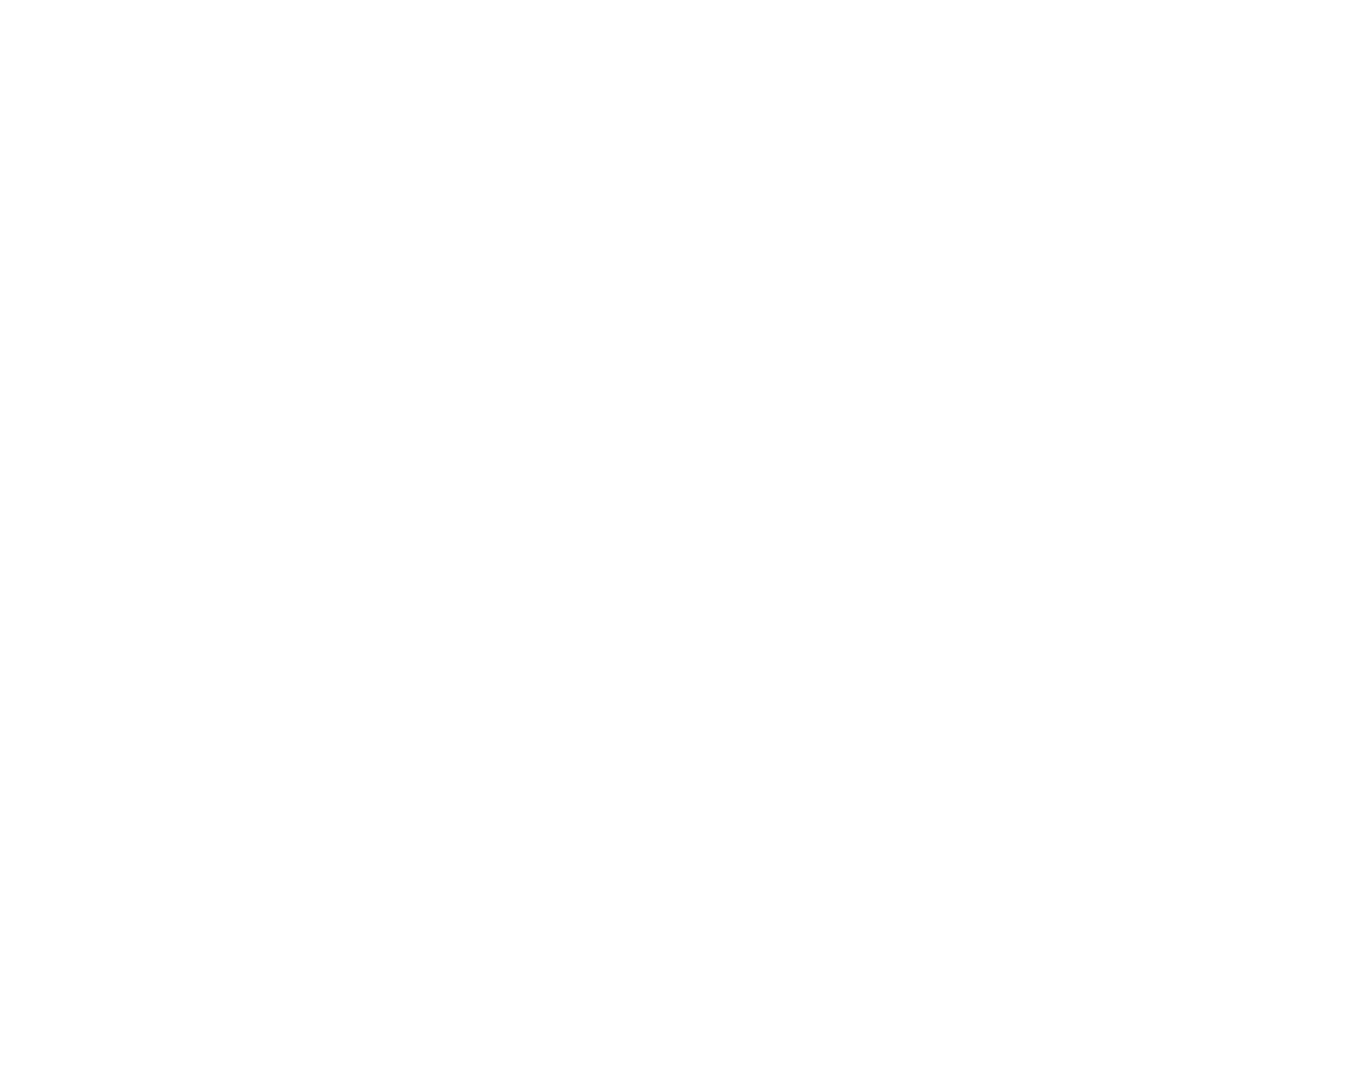

<IPython.core.display.Javascript object>


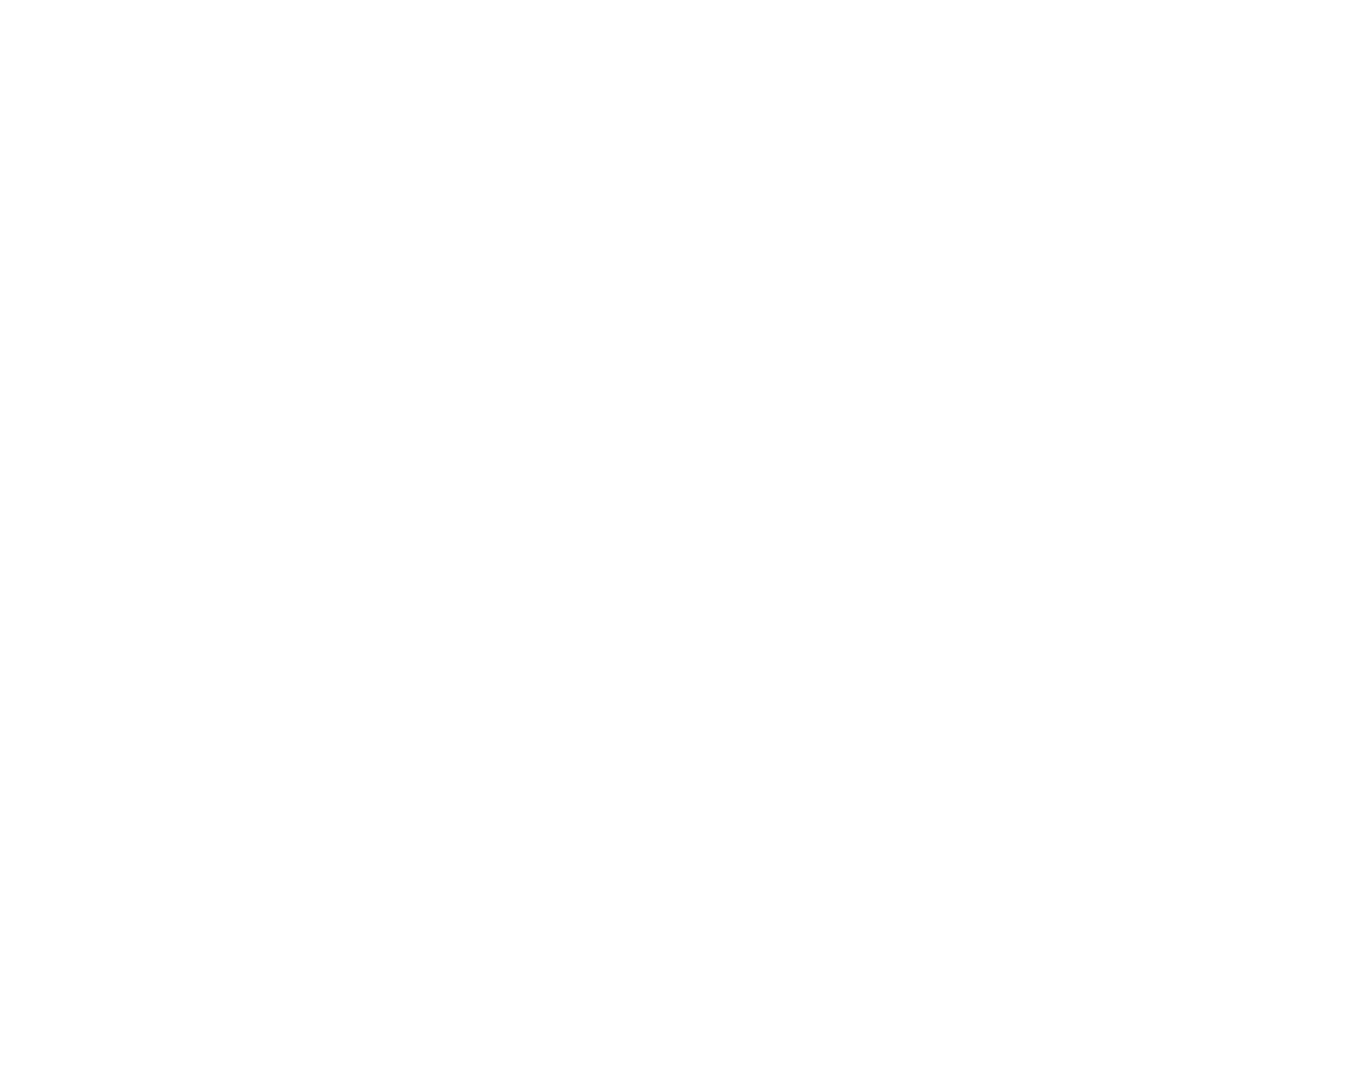

<IPython.core.display.Javascript object>


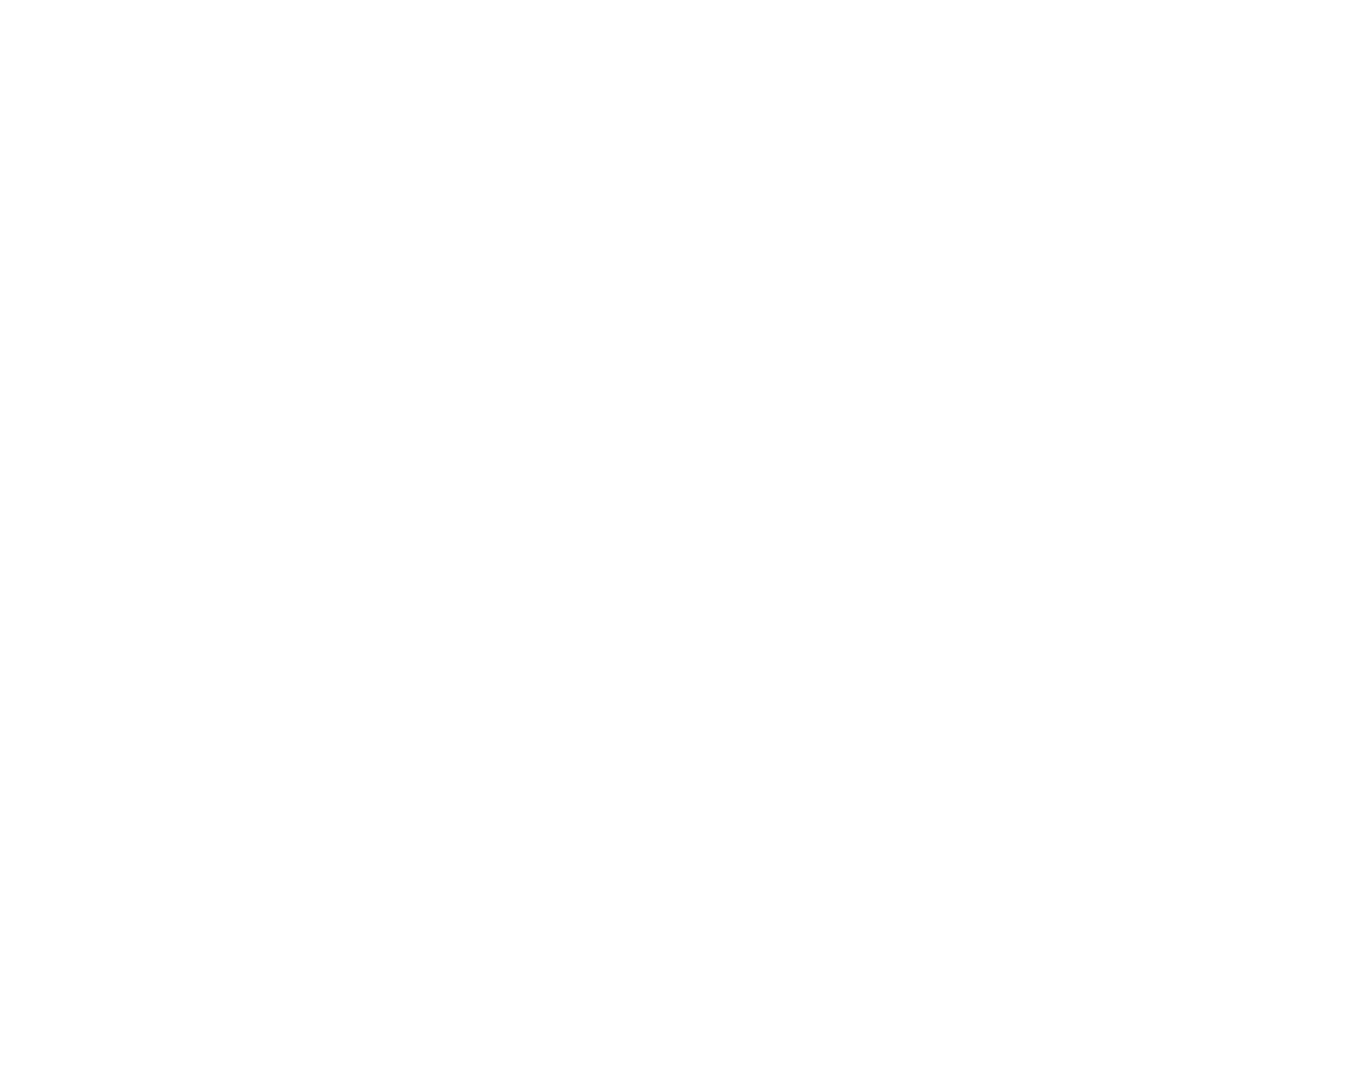

<IPython.core.display.Javascript object>


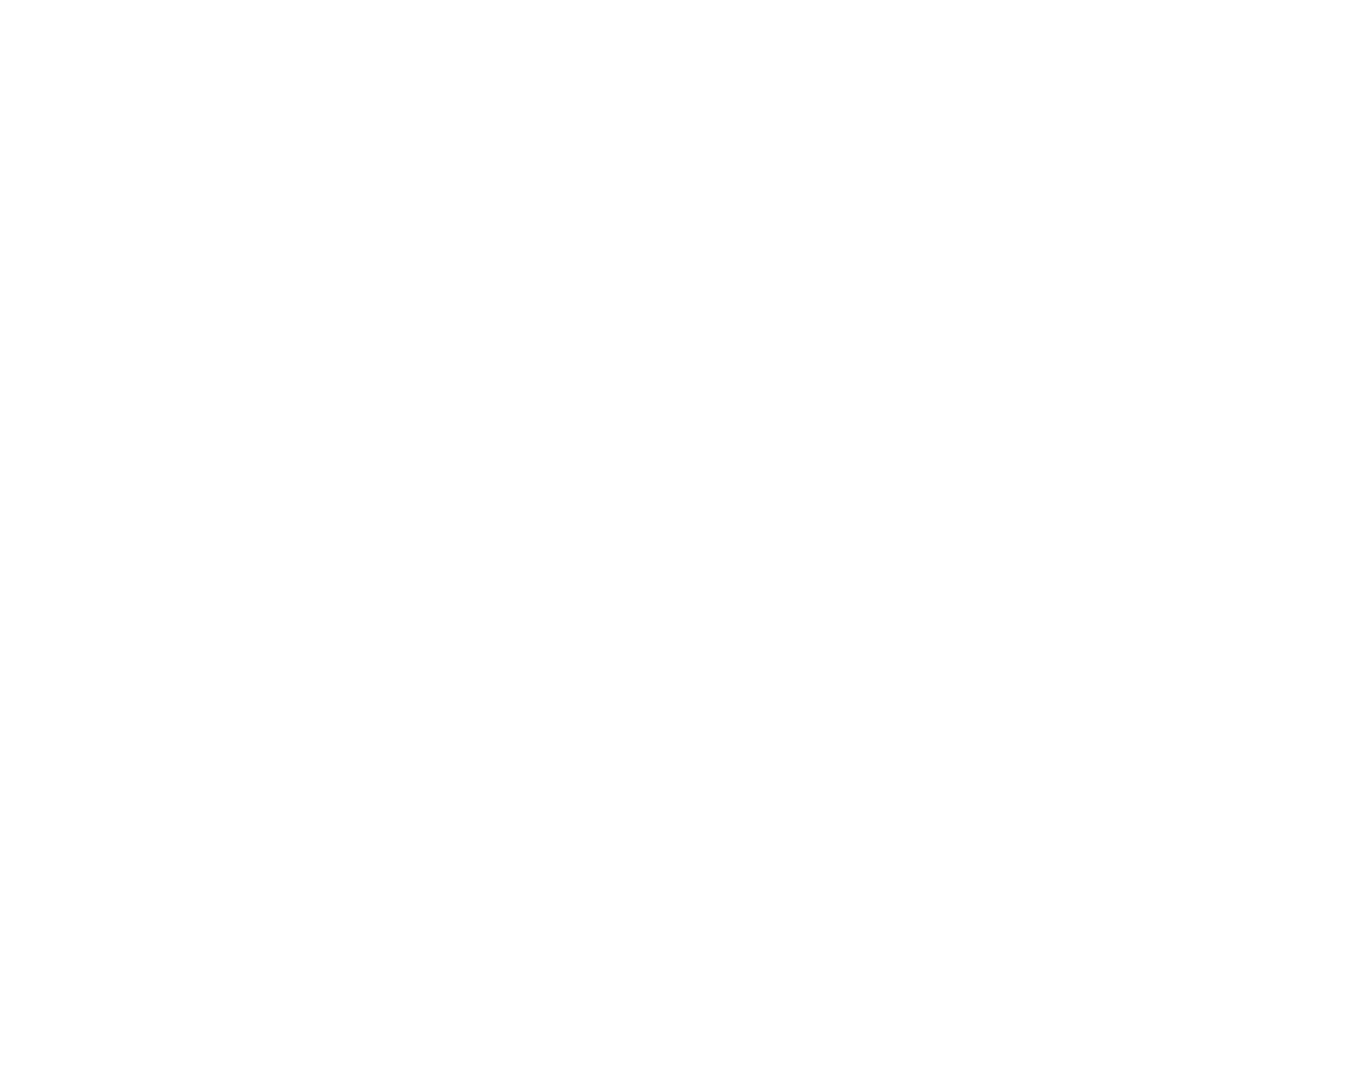

<IPython.core.display.Javascript object>


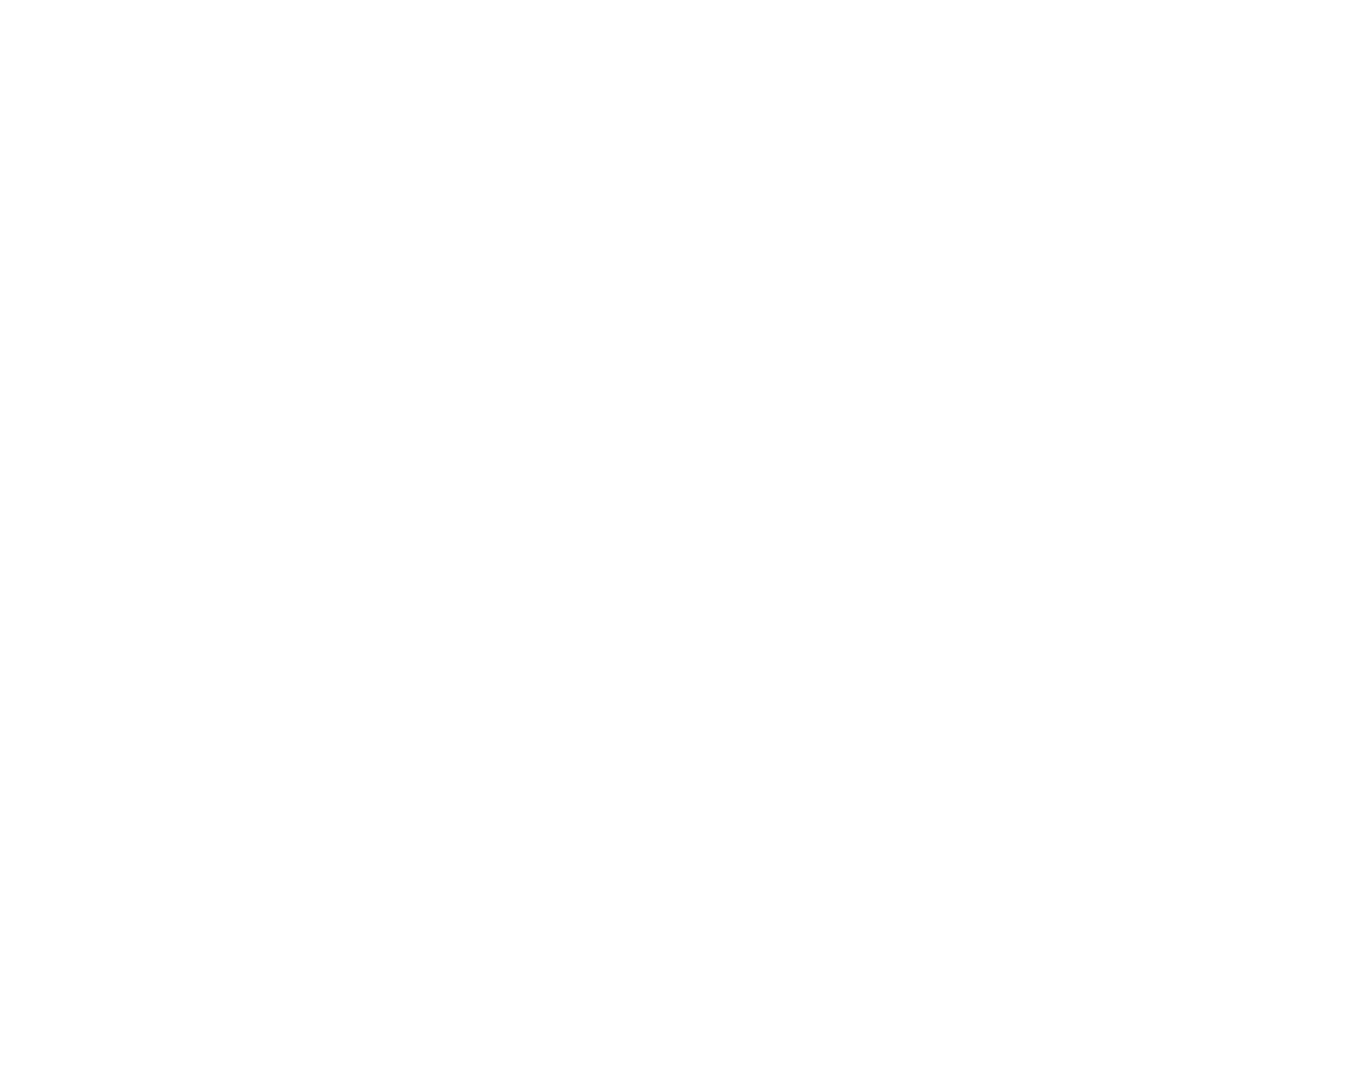

<IPython.core.display.Javascript object>


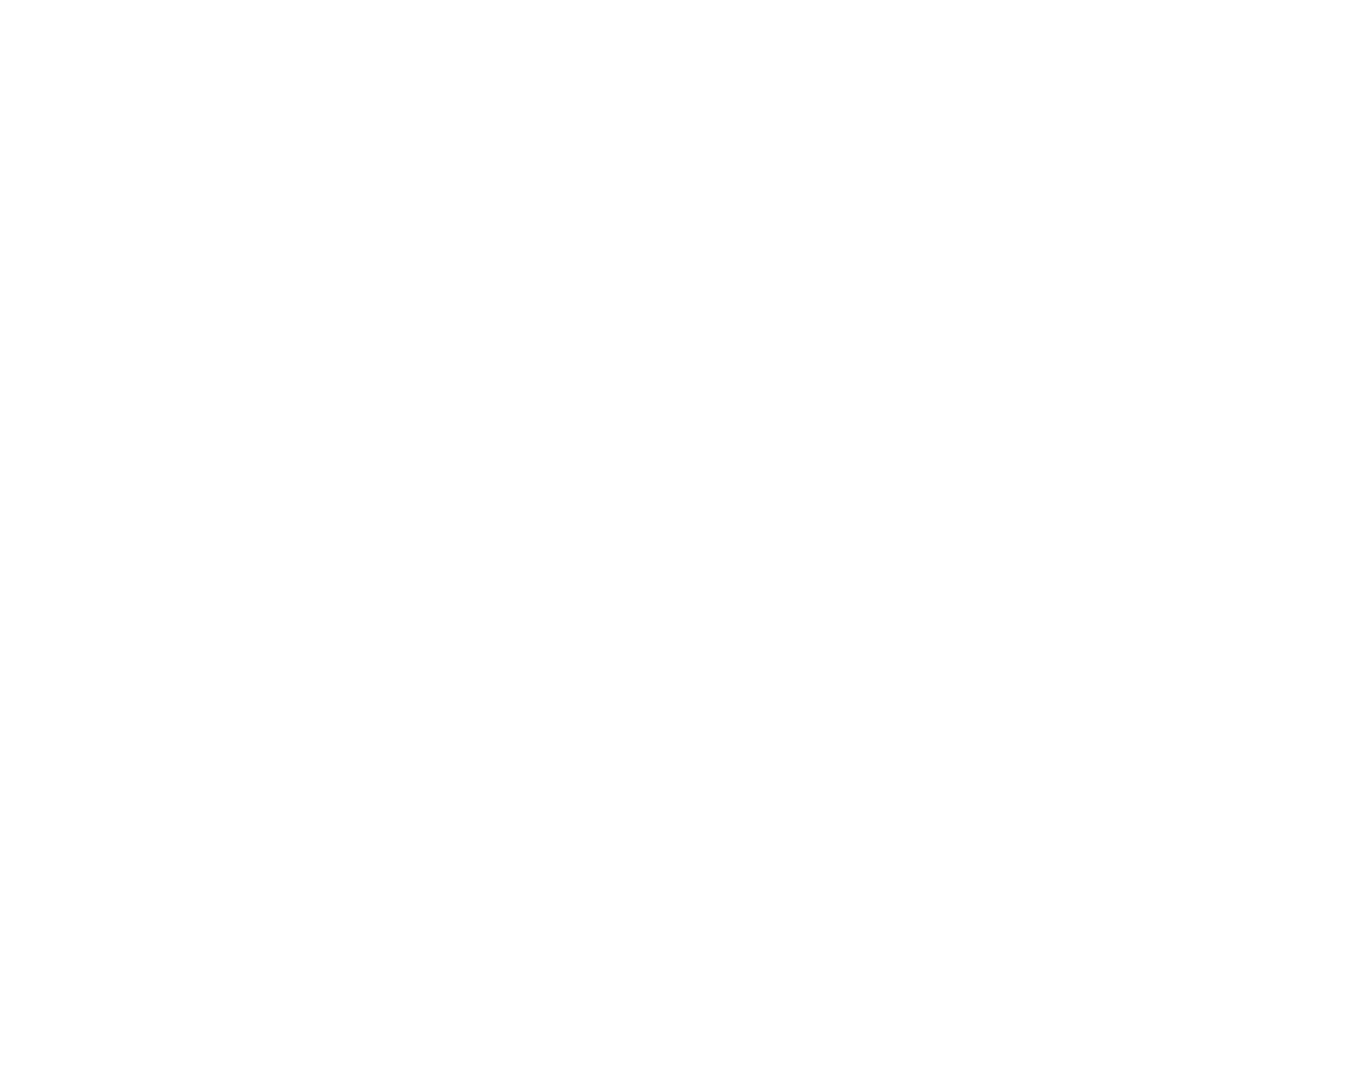

<IPython.core.display.Javascript object>


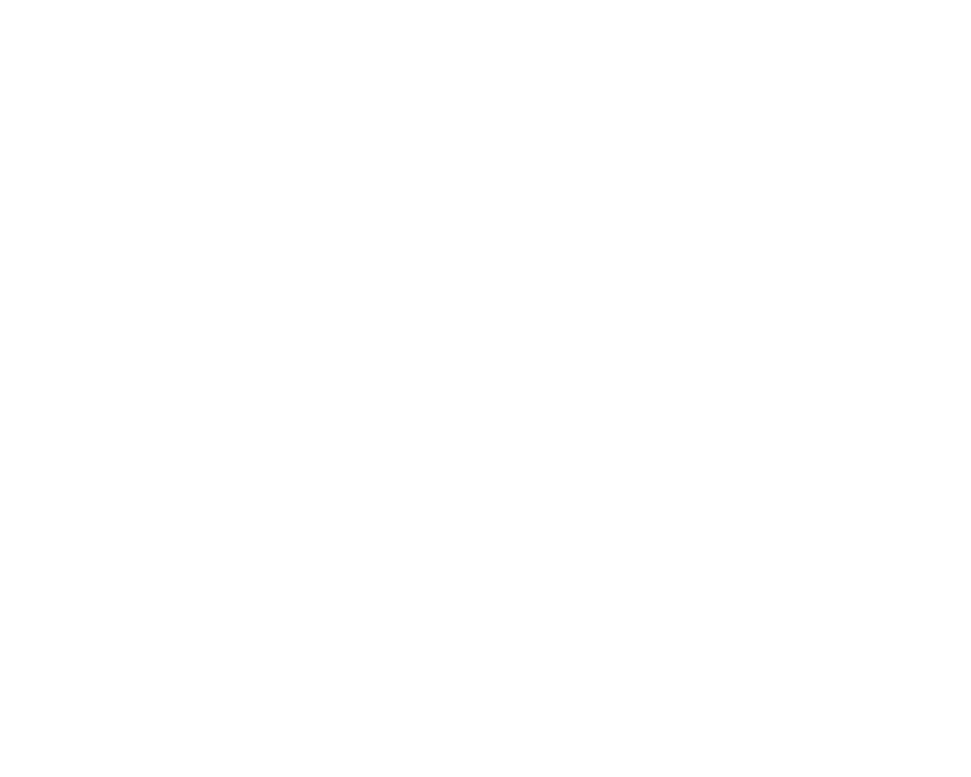

<IPython.core.display.Javascript object>


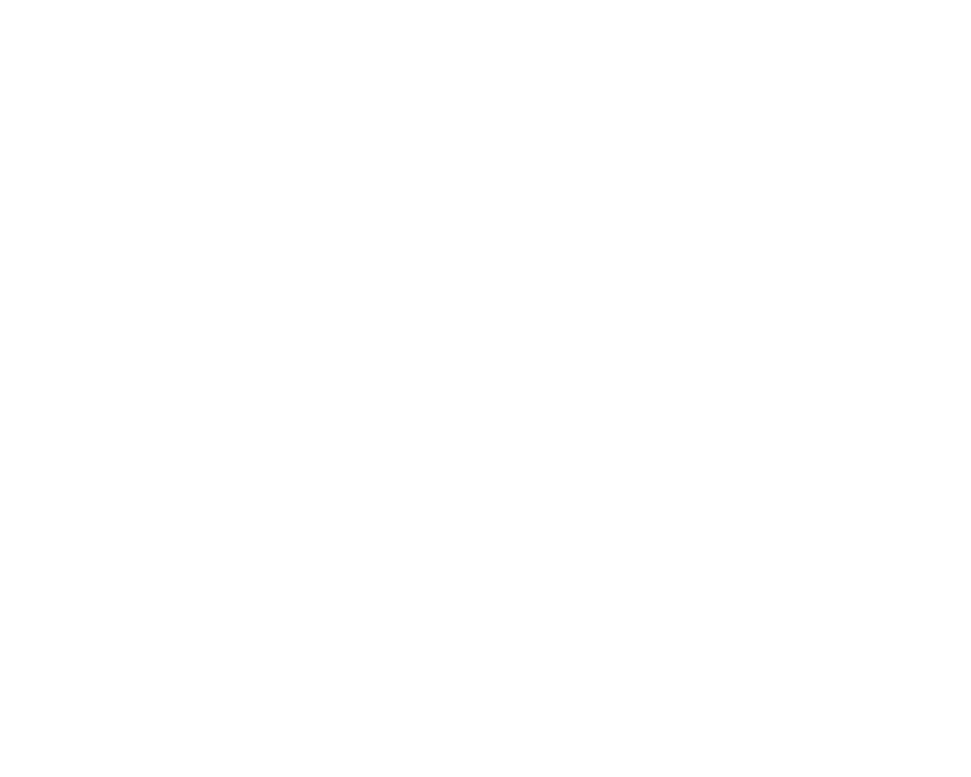

<IPython.core.display.Javascript object>


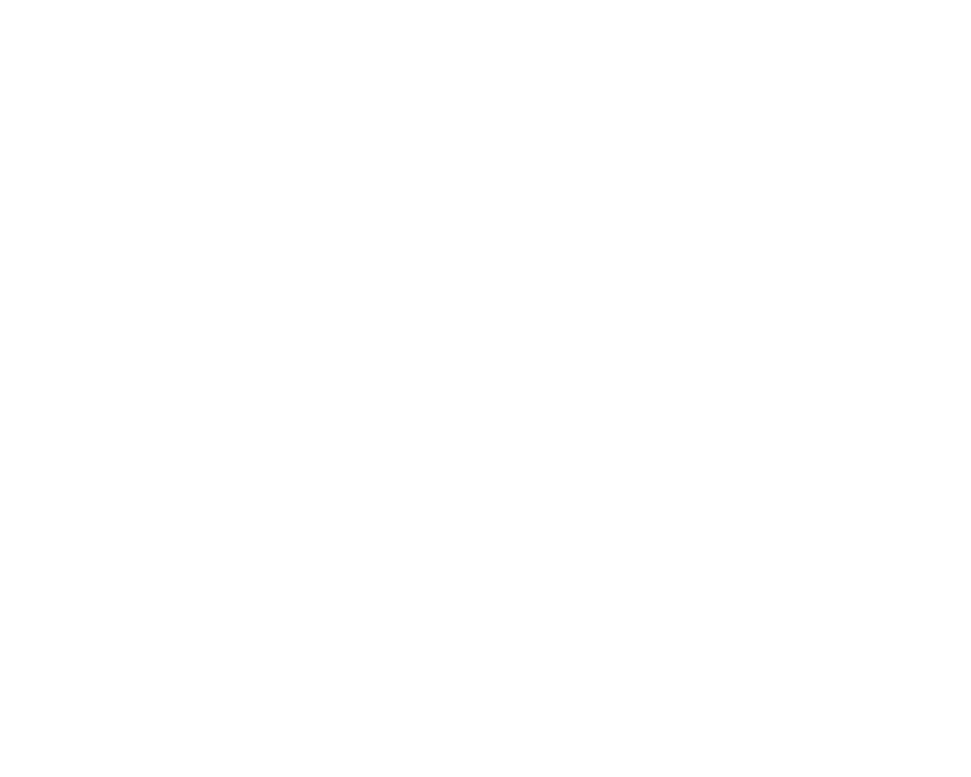

<IPython.core.display.Javascript object>


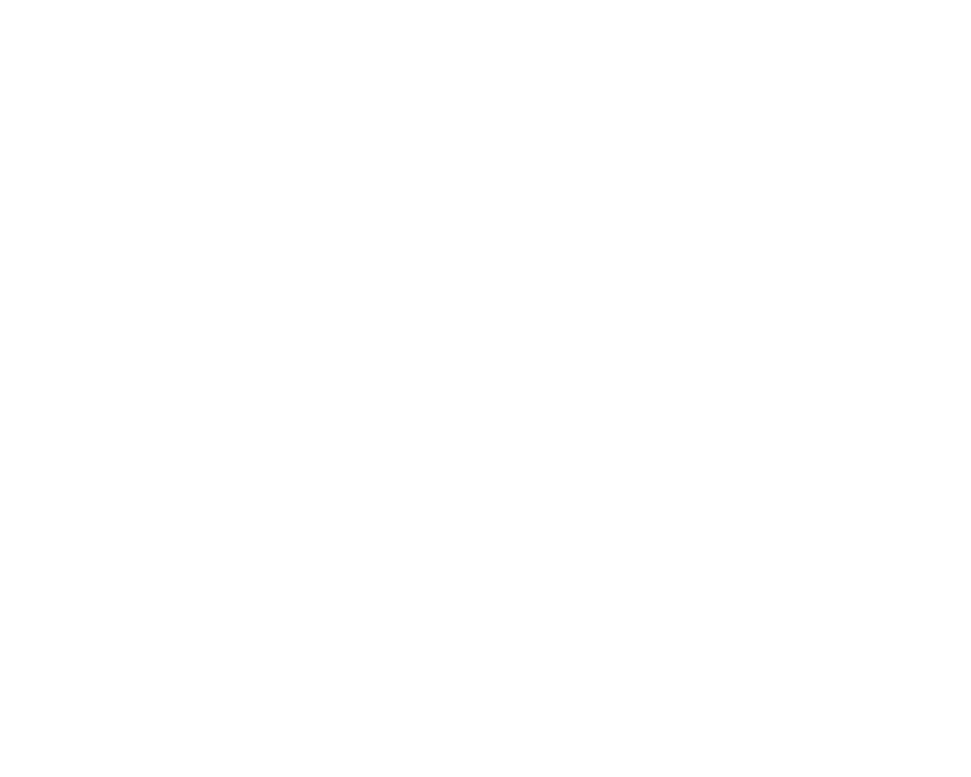

<IPython.core.display.Javascript object>


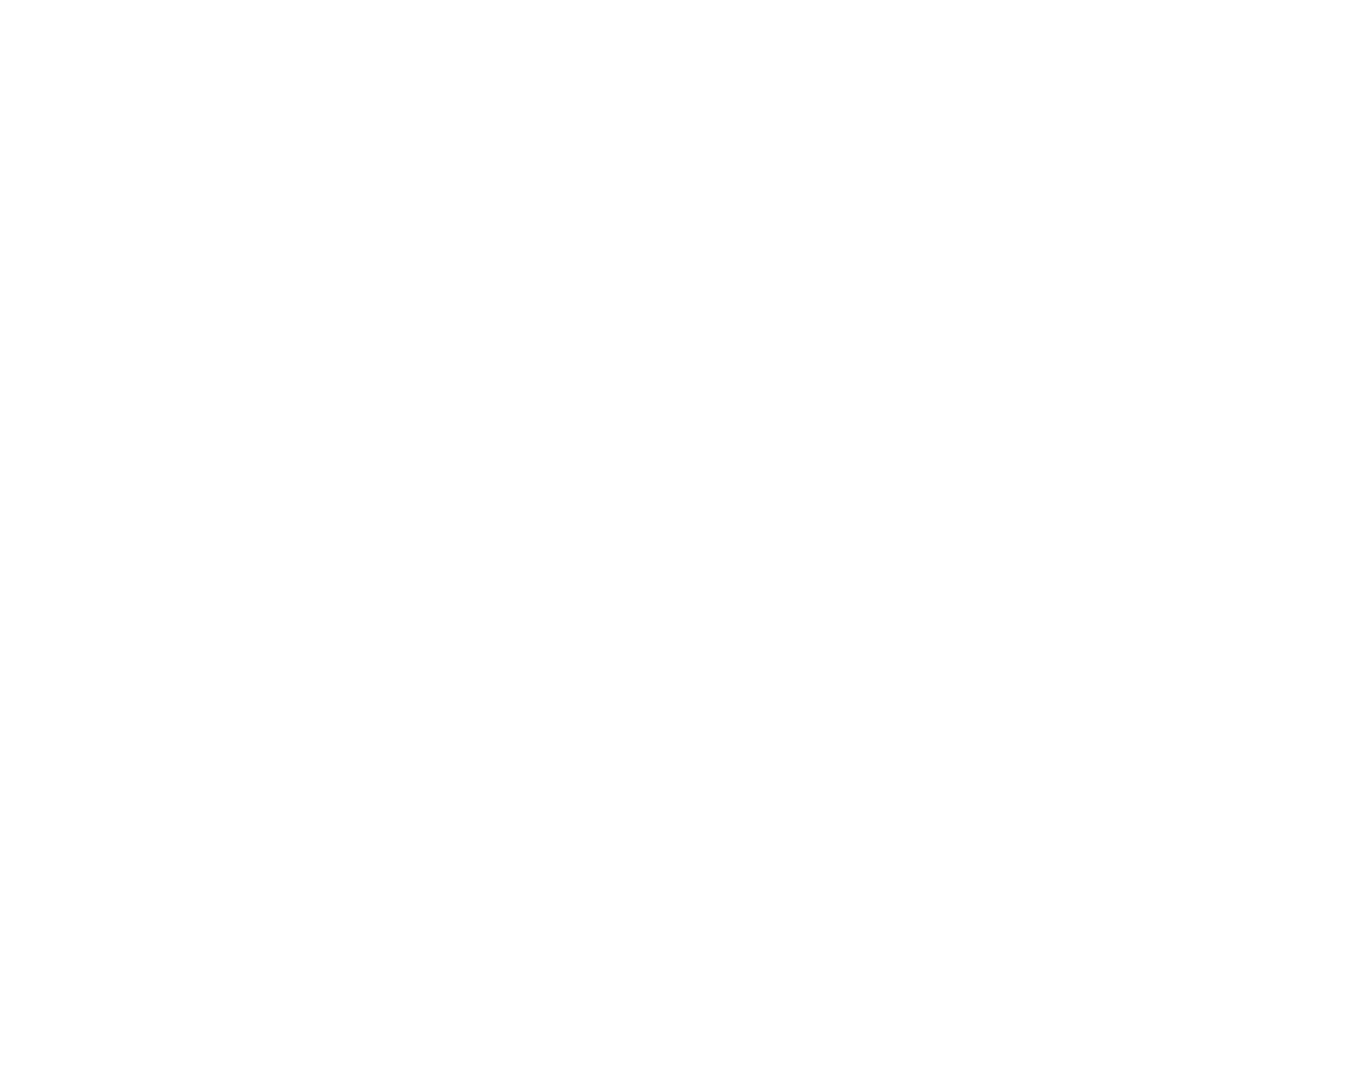

<IPython.core.display.Javascript object>


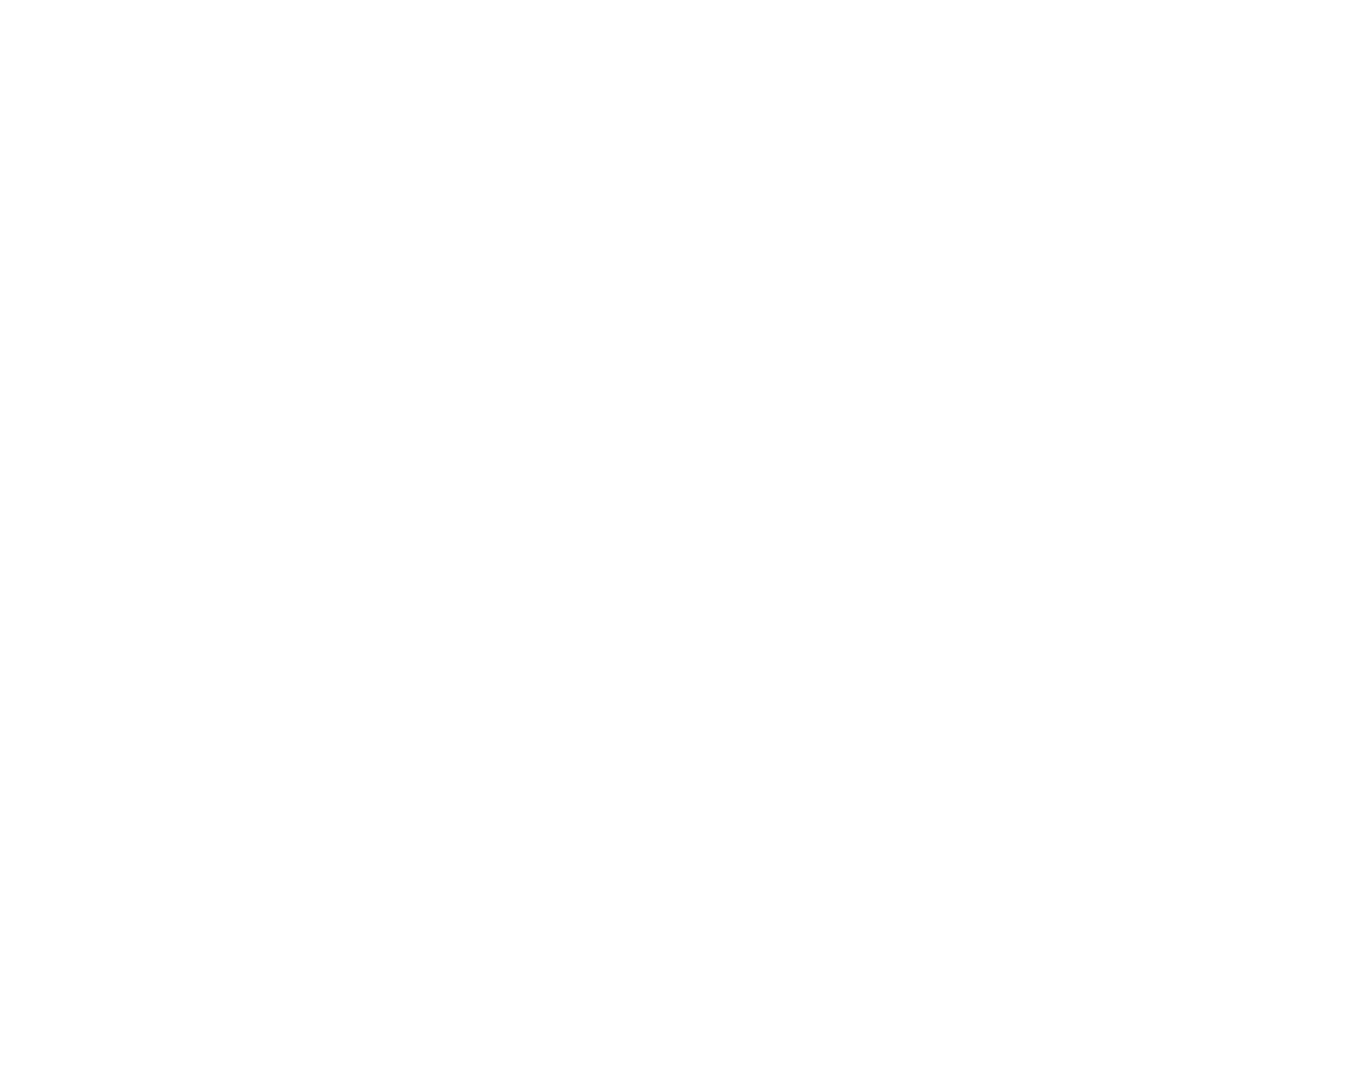

In [70]:
movie_binary_ngrams_models = load_models('movie_binary_ngrams', model_suffix)

In [71]:
movie_binary_ngrams_models
#These models have all been pre-trained
#They can be reproduced exactly by using the parameters shown here with the random_state of 42, and training on movie_binary_ngrams

{'nb': MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True),
 'lr': LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0.2, max_iter=100000,
                    multi_class='auto', n_jobs=-1, penalty='elasticnet',
                    random_state=42, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'ada': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                    n_estimators=1000, random_state=42),
 'forest': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=50, max_features=0.25,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=16,
                        min_weight_fraction_leaf=0.0, n_estimators=200,
          

In [72]:
movie_binary_ngrams_estimators = []
movie_binary_ngrams_weights = []

for name, model in movie_binary_ngrams_models.items():
    if name != 'dec_tree' and name != 'forest' and name != 'ada':
        movie_binary_ngrams_estimators.append(model)
        movie_binary_ngrams_weights.append(movie_binary_ngrams_accuracies[name] / movie_binary_ngrams_accuracies_max)

    
movie_binary_ngrams_ensemble = EnsembleVoteClassifier(movie_binary_ngrams_estimators, voting='hard', weights = movie_binary_ngrams_weights, refit=False)


C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


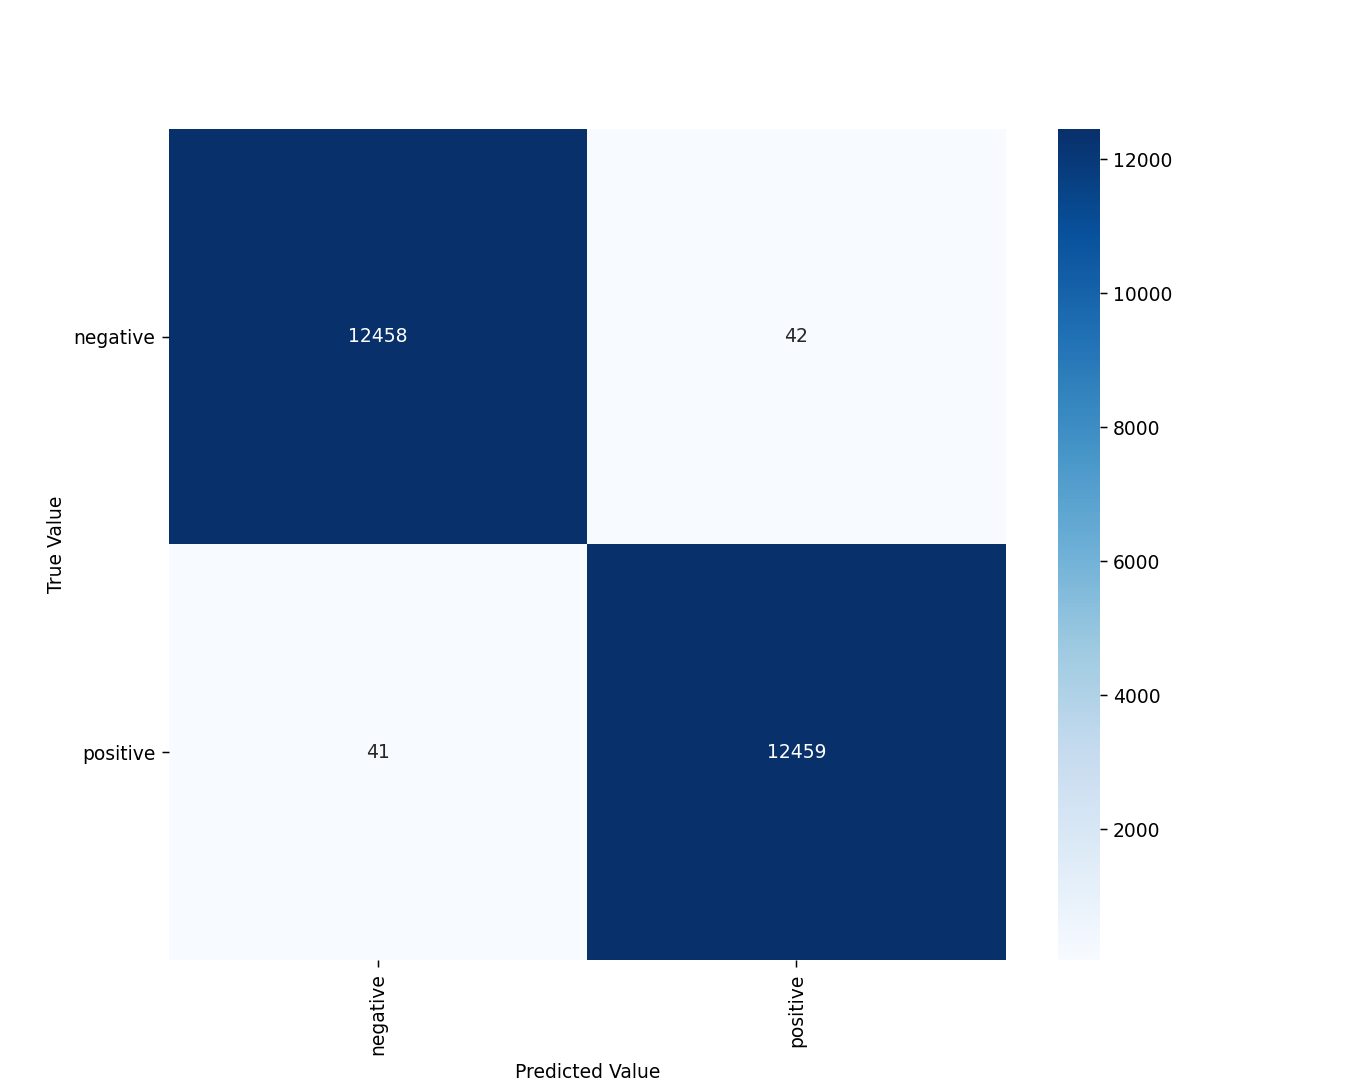

<IPython.core.display.Javascript object>


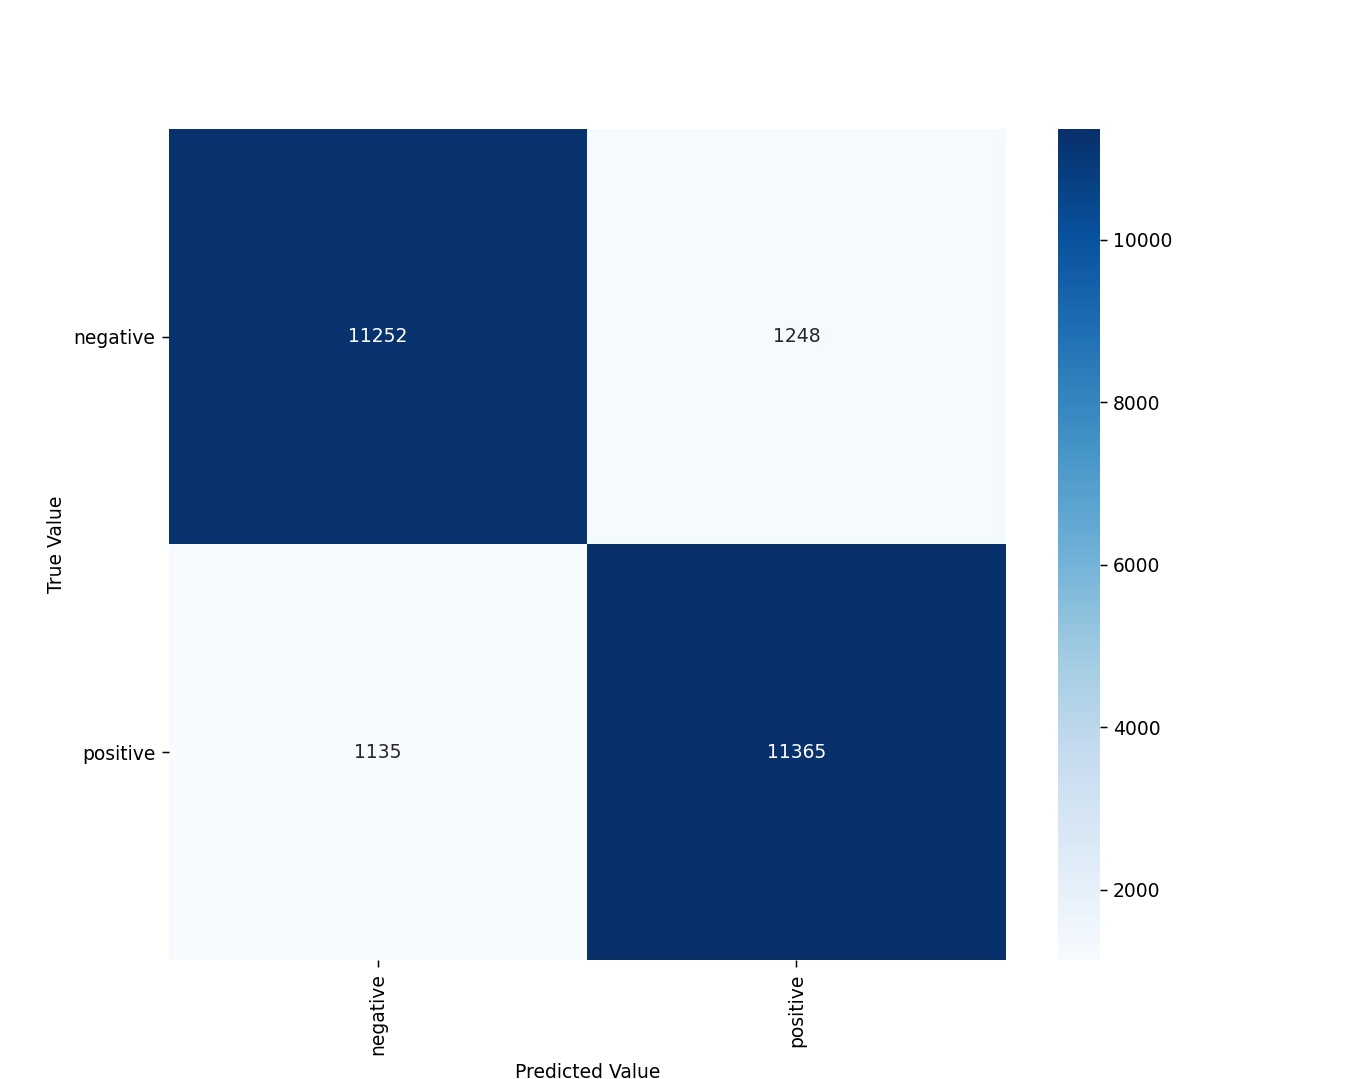

In [73]:
movie_binary_ngrams_results_ensemble = ensemble_eval_save("movie_binary_ngrams_results_ensemble.pkl", movie_binary_ngrams_ensemble, movie['movie_binary_ngrams']['X_train'], movie['movie_binary_ngrams']['y_train'],
             movie['movie_binary_ngrams']['X_test'], movie['movie_binary_ngrams']['y_test'], movie_labels,'binary')

In [74]:
movie_binary_ngrams_results_ensemble

{'model': EnsembleVoteClassifier(clfs=[MultinomialNB(alpha=0.1, class_prior=None,
                                            fit_prior=True),
                              LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=0.2, max_iter=100000,
                                                 multi_class='auto', n_jobs=-1,
                                                 penalty='elasticnet',
                                                 random_state=42, solver='saga',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False),
                              AdaBoostClassifier(algor...
                                                 learning_rate=0.1,
                                                 n_est

## Soft Ensemble

First we use the optimal LinearSVC parameters to train an SVC classifier with a linear kernel, capable of outputting probabilities. 

In [21]:
movie_binary_ngrams_svc = SVC(C = 0.54, kernel='linear', probability=True, max_iter = 10000, cache_size = 20000,
                             break_ties=False, random_state=42)

In [22]:
movie_binary_ngrams_svc.fit(movie['movie_binary_ngrams']['X_train'], movie['movie_binary_ngrams']['y_train'])

C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=0.54, break_ties=False, cache_size=20000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=10000, probability=True, random_state=42, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
with open("movie_binary_ngrams_svc.pkl", 'wb') as f:
        pickle.dump(movie_binary_ngrams_svc, f) 

In [11]:
movie_binary_ngrams_svc = pickle.load(open("movie_binary_ngrams_svc.pkl", 'rb'))


In [12]:
train_results = evaluate_model(movie_binary_ngrams_svc, movie['movie_binary_ngrams']['X_train'], movie['movie_binary_ngrams']['y_train'], movie_labels, 'binary')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


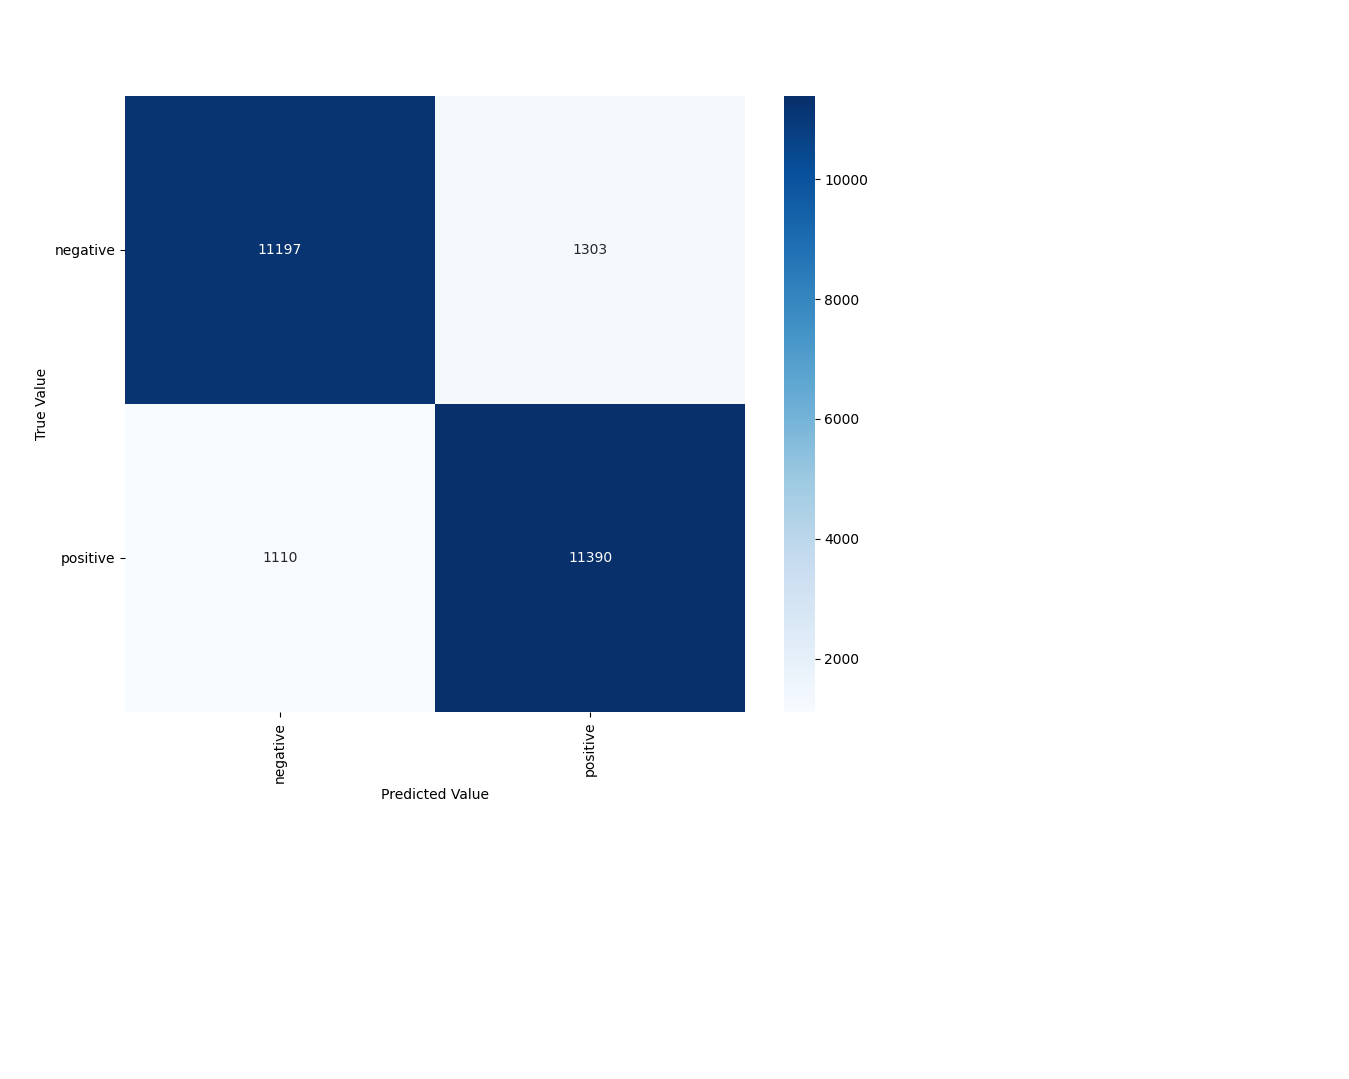

In [13]:
test_results = evaluate_model(movie_binary_ngrams_svc, movie['movie_binary_ngrams']['X_test'], movie['movie_binary_ngrams']['y_test'], movie_labels, 'binary')

In [15]:
movie_binary_ngrams_results_svc_proba = {'model': movie_binary_ngrams_svc, 'train_results': train_results, 'test_results': test_results} 
with open("movie_binary_ngrams_results_svc.pkl", 'wb') as f:
    pickle.dump(movie_binary_ngrams_results_svc_proba, f)

In [16]:
movie_binary_ngrams_results_svc_proba

{'model': SVC(C=0.54, break_ties=False, cache_size=20000, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
     max_iter=10000, probability=True, random_state=42, shrinking=True,
     tol=0.001, verbose=False),
 'train_results': {'acc': 0.9732,
  'f1': 0.9733216532611291,
  'conf_matrix': array([[12108,   392],
         [  278, 12222]], dtype=int64),
  'conf_matrix_plot': <Figure size 1000x800 with 2 Axes>},
 'test_results': {'acc': 0.90348,
  'f1': 0.9042194260310404,
  'conf_matrix': array([[11197,  1303],
         [ 1110, 11390]], dtype=int64),
  'conf_matrix_plot': <Figure size 1000x800 with 2 Axes>}}

In [64]:
movie_binary_ngrams_accuracies_soft = movie_binary_ngrams_accuracies
del movie_binary_ngrams_accuracies_soft['linear_svc']
movie_binary_ngrams_accuracies_soft['svc'] = 0.90348
movie_binary_ngrams_accuracies_soft_max = max(movie_binary_ngrams_accuracies_soft.values())

movie_binary_ngrams_models_soft = movie_binary_ngrams_models
del movie_binary_ngrams_models_soft['linear_svc']
movie_binary_ngrams_models_soft['svc'] = movie_binary_ngrams_svc

movie_binary_ngrams_estimators_soft = []
movie_binary_ngrams_weights_soft = []

for name, model in movie_binary_ngrams_models_soft.items():
    if name != 'forest' and name != 'dec_tree' and name != 'ada':
        movie_binary_ngrams_estimators_soft.append(model)
        movie_binary_ngrams_weights_soft.append(movie_binary_ngrams_accuracies_soft[name] / movie_binary_ngrams_accuracies_soft_max)

movie_binary_ngrams_ensemble_weights_soft = EnsembleVoteClassifier(movie_binary_ngrams_estimators_soft, weights = movie_binary_ngrams_weights_soft, voting='soft', refit=False)

C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


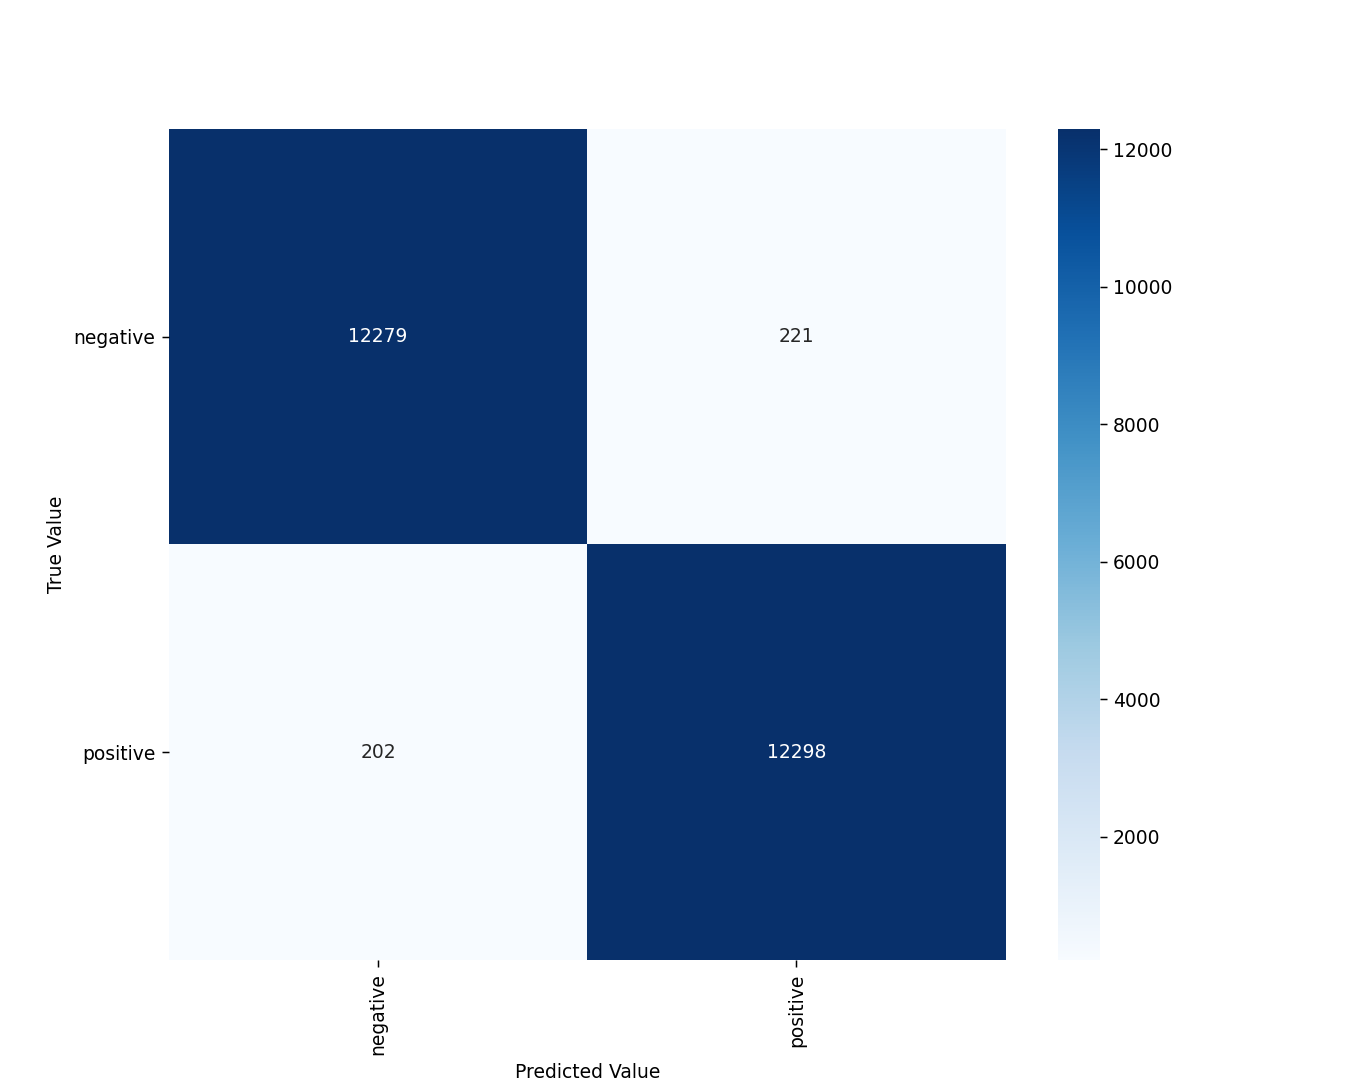

<IPython.core.display.Javascript object>


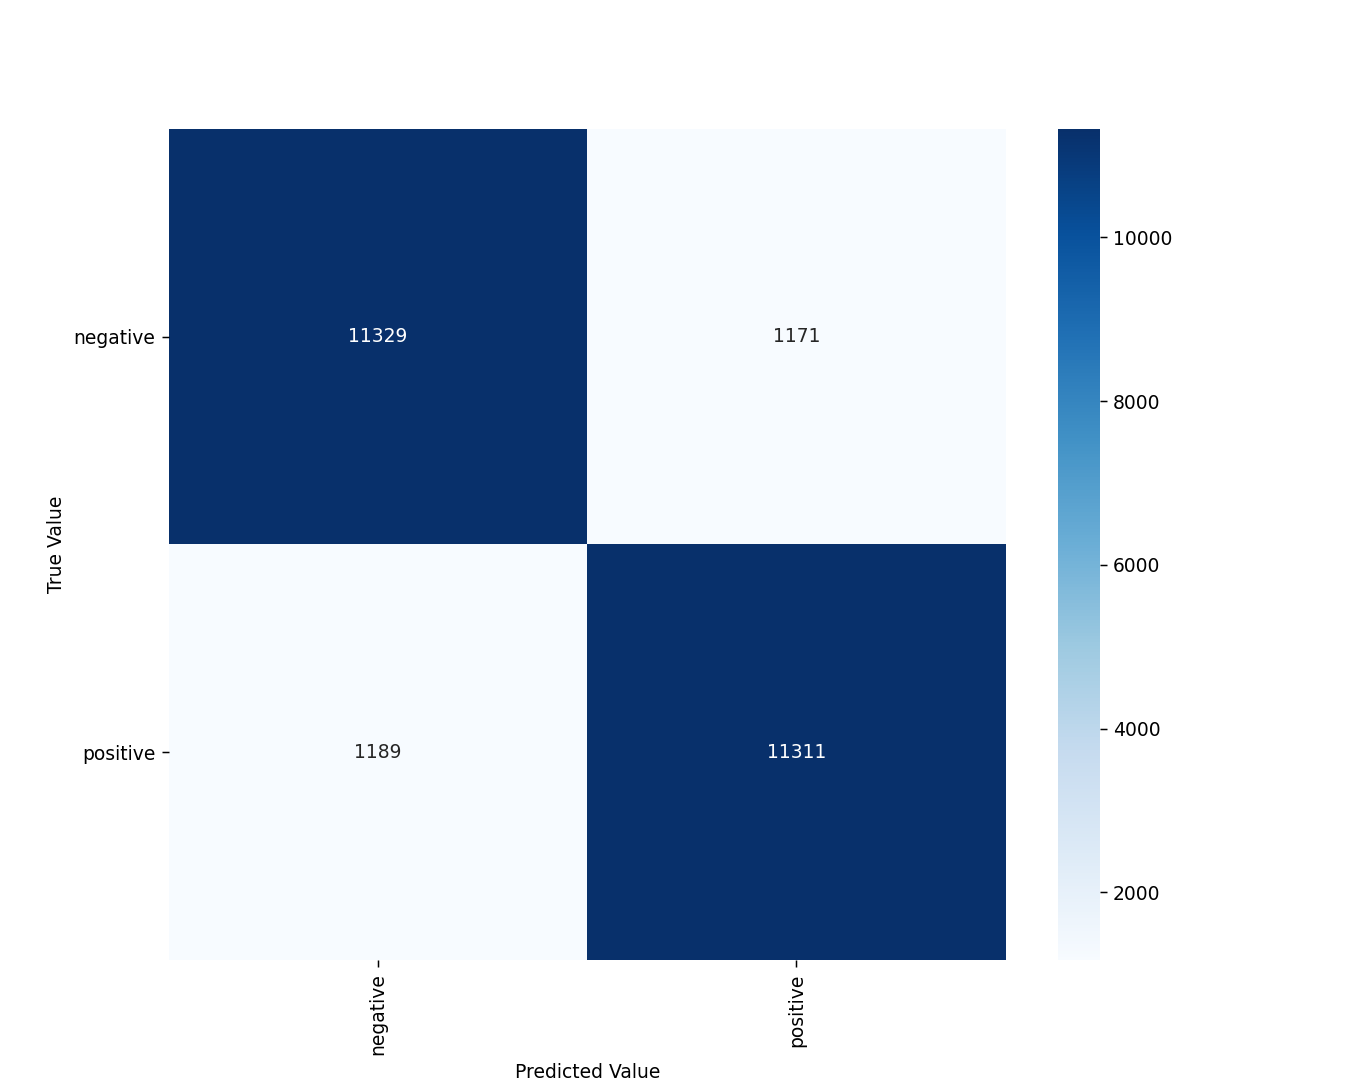

In [65]:
movie_binary_ngrams_results_ensemble_weights_soft = ensemble_eval_save("movie_binary_ngrams_results_ensemble_weights_soft.pkl", movie_binary_ngrams_ensemble_weights_soft, movie['movie_binary_ngrams']['X_train'], movie['movie_binary_ngrams']['y_train'],
             movie['movie_binary_ngrams']['X_test'], movie['movie_binary_ngrams']['y_test'], movie_labels,'binary')

In [66]:
movie_binary_ngrams_results_ensemble_weights_soft

{'model': EnsembleVoteClassifier(clfs=[MultinomialNB(alpha=0.1, class_prior=None,
                                            fit_prior=True),
                              LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=0.2, max_iter=100000,
                                                 multi_class='auto', n_jobs=-1,
                                                 penalty='elasticnet',
                                                 random_state=42, solver='saga',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False),
                              SVC(C=0.54, break_ties=False, cache_size=20000,
                                  class_weight=None, coef0=0.0,
                                  deci

## Stacking Ensemble

In [ ]:
#Voting , remove any classifiers not needed
movie_binary_ngrams_estimators_stack = []
movie_binary_ngrams_weights_stack = []

for name, model in movie_binary_ngrams_models.items():
    movie_binary_ngrams_estimators_stack.append(model)
    movie_binary_ngrams_weights_stack.append(movie_binary_ngrams_accuracies[name] / movie_binary_ngrams_accuracies_max)

meta_lr = LogisticRegression()    

movie_binary_ngrams_ensemble_stack = StackingCVClassifier(classifiers = movie_binary_ngrams_estimators, meta_classifier = meta_lr, 
                                                          cv=5, random_state=42, verbose=2, n_jobs=-1)


In [108]:
movie_binary_ngrams_results_ensemble_stack = ensemble_eval_save("movie_binary_ngrams_results_ensemble_stack.pkl", movie_binary_ngrams_ensemble_stack, movie['movie_binary_ngrams']['X_train'], movie['movie_binary_ngrams']['y_train'],
             movie['movie_binary_ngrams']['X_test'], movie['movie_binary_ngrams']['y_test'], movie_labels,'binary')

Fitting 4 classifiers...
Fitting classifier1: multinomialnb (1/4)
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: logisticregression (2/4)
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=100000,
                   multi_class='auto', n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.9min remaining: 16.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.4min remaining:    0.0s


KeyboardInterrupt: 

In [ ]:
movie_binary_ngrams_results_ensemble_stack

# news_binary_ngrams

In [94]:
news_binary_ngrams_accuracies = {
    'linear_svc': 0.69238,
    'dec_tree': 0.34838,
    'ada': 0.44145,
    'nb': 0.66968,
    'lr': 0.68016,
    'forest': 0.48699
}

news_binary_ngrams_accuracies_max = max(news_binary_ngrams_accuracies.values())

<IPython.core.display.Javascript object>


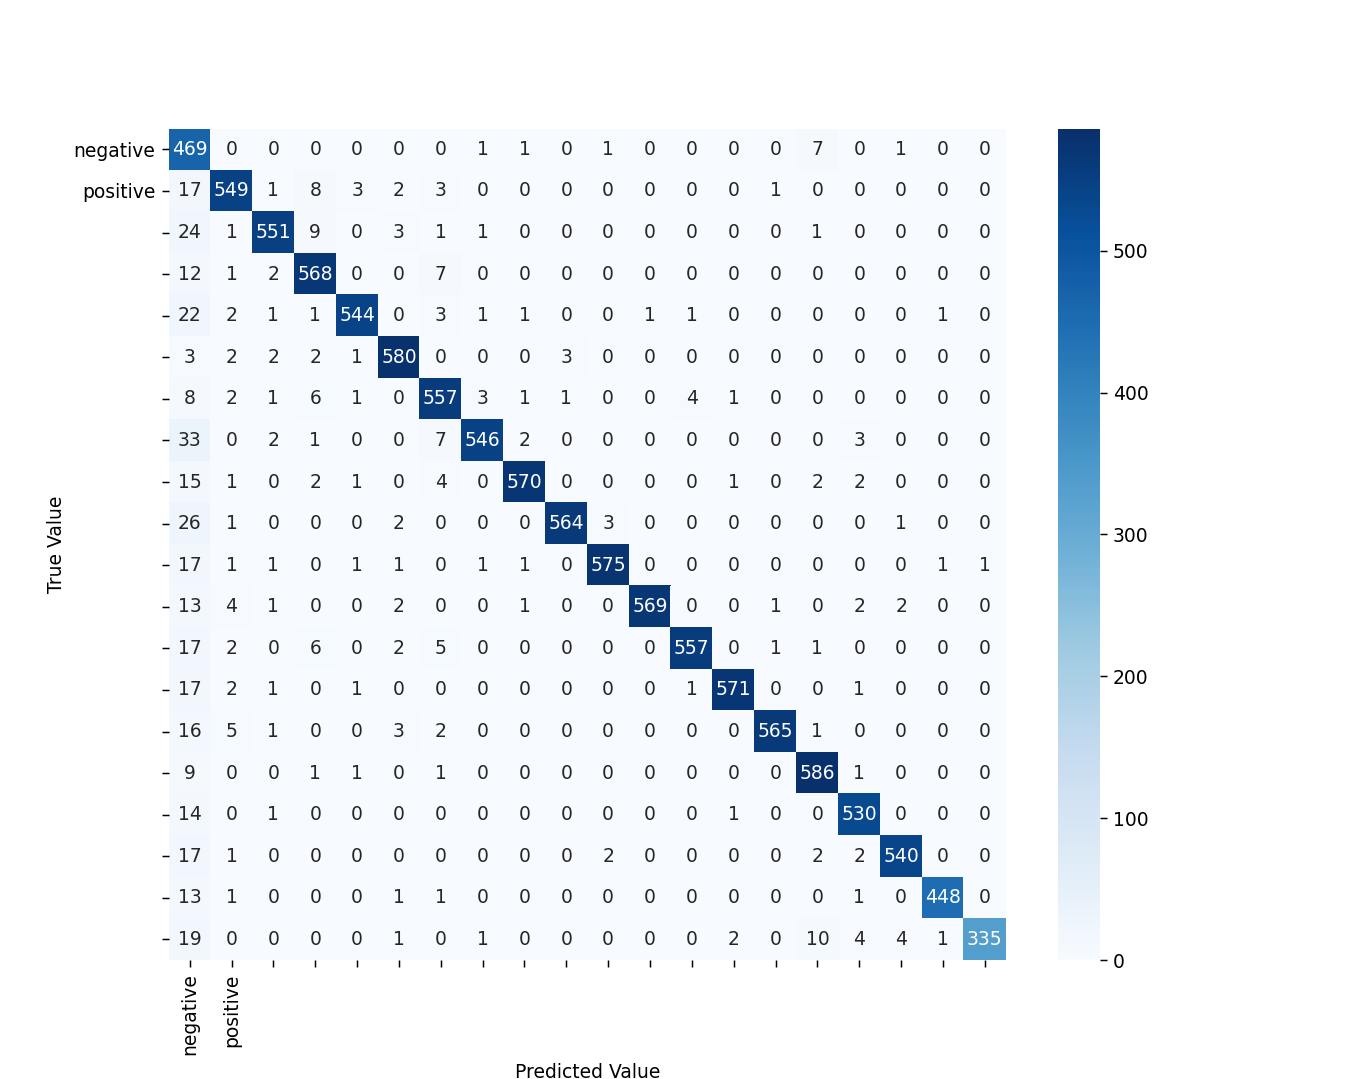

<IPython.core.display.Javascript object>


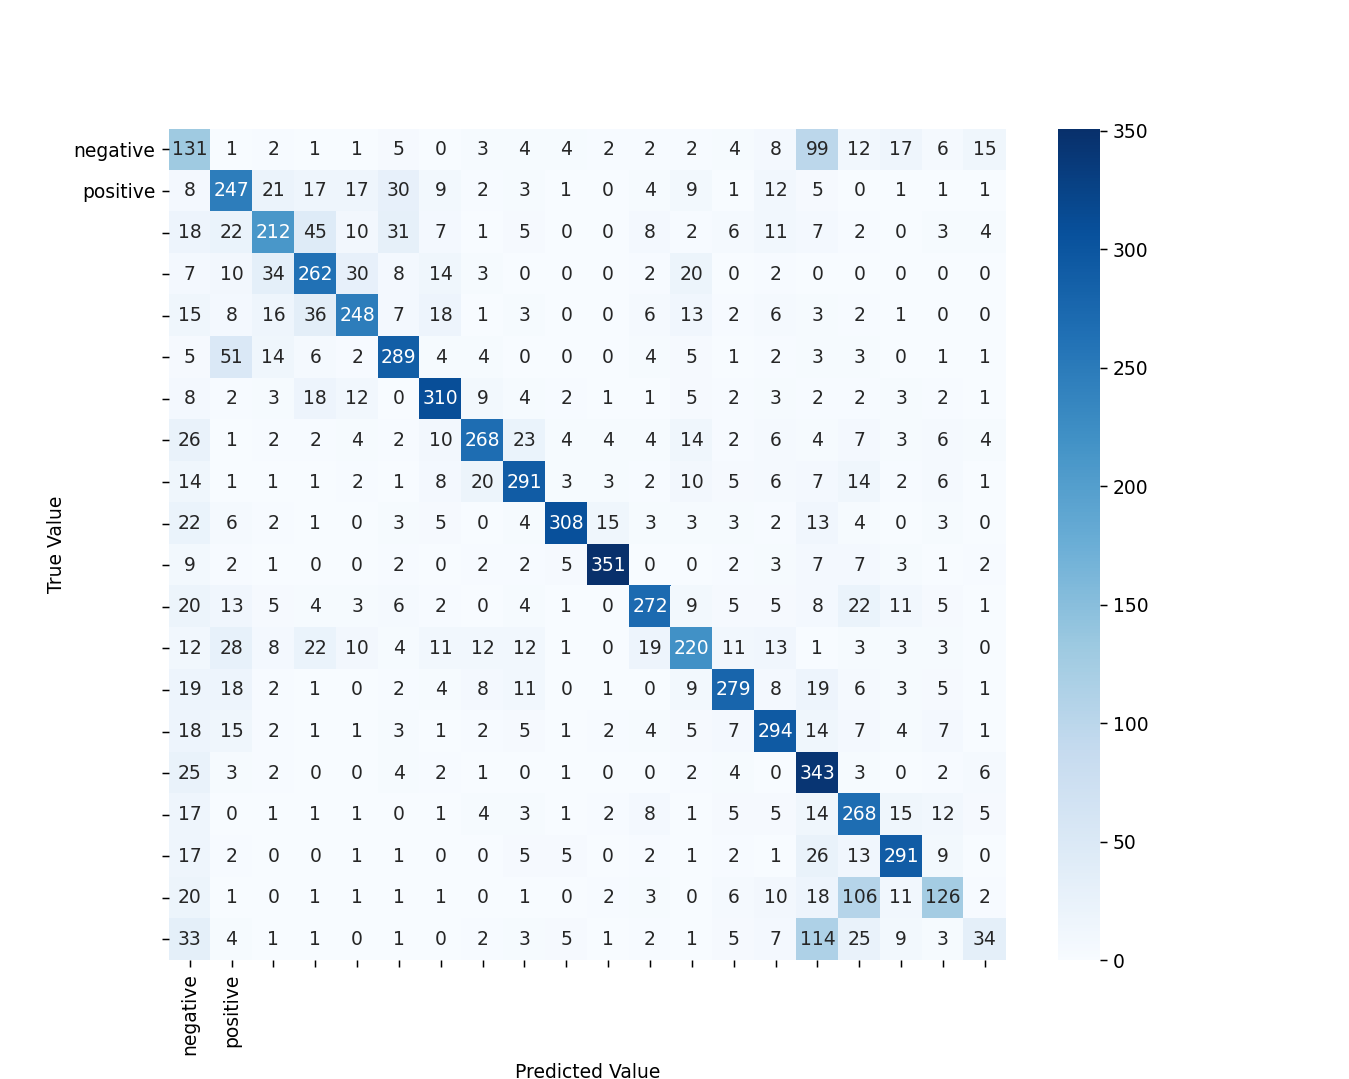

C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:38: UserWarning: This figure was saved with matplotlib version 3.1.1 and is unlikely to function correctly.


<IPython.core.display.Javascript object>


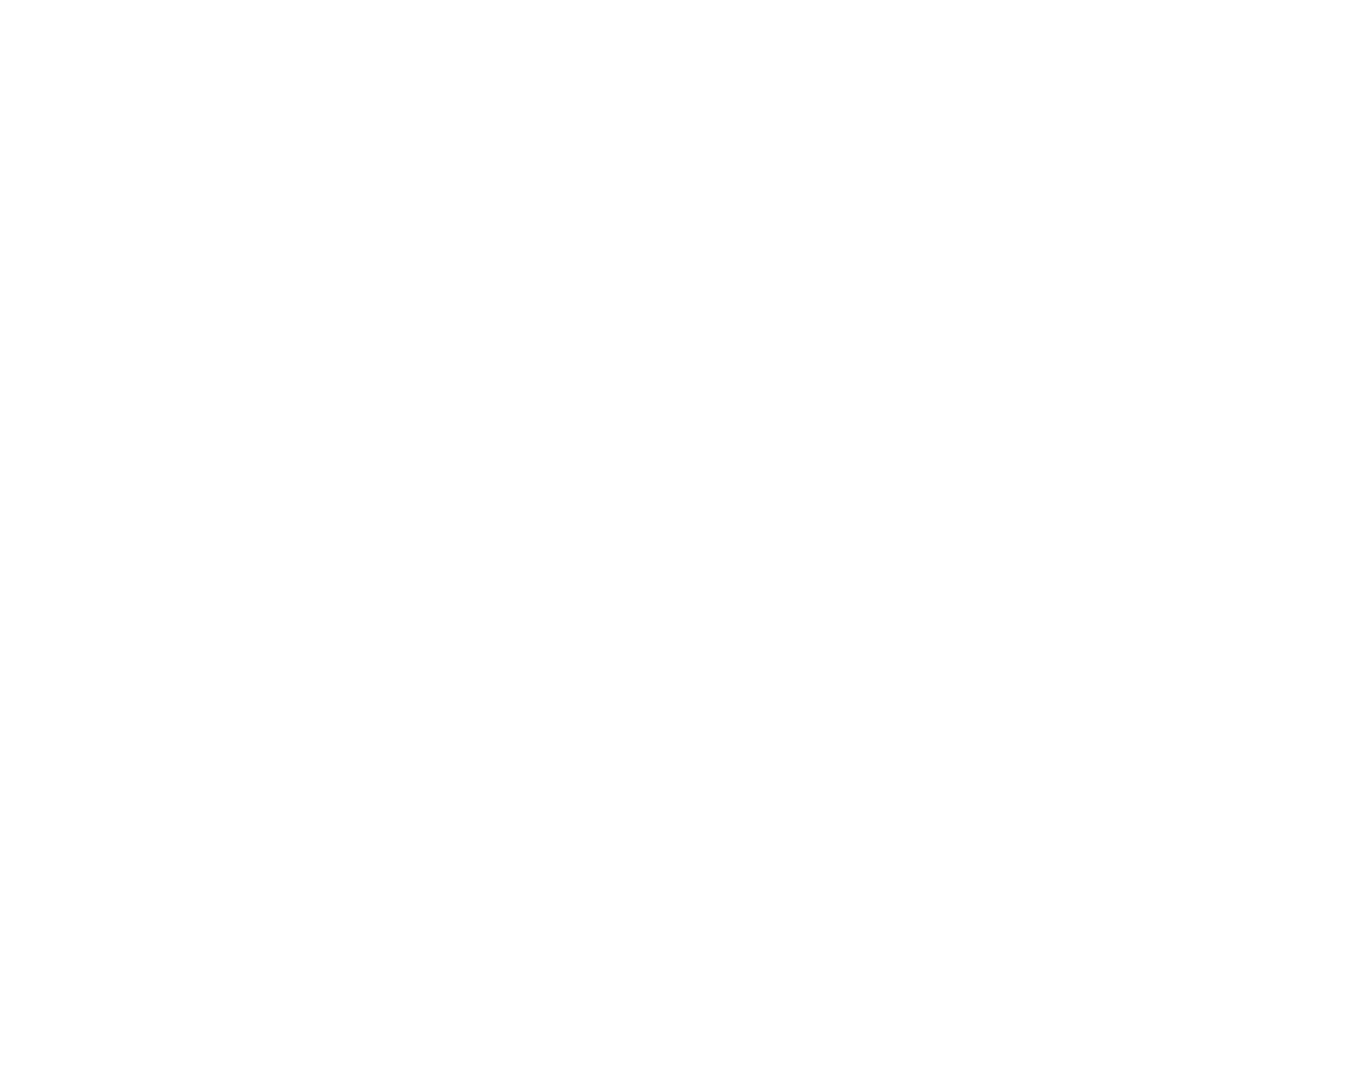

<IPython.core.display.Javascript object>


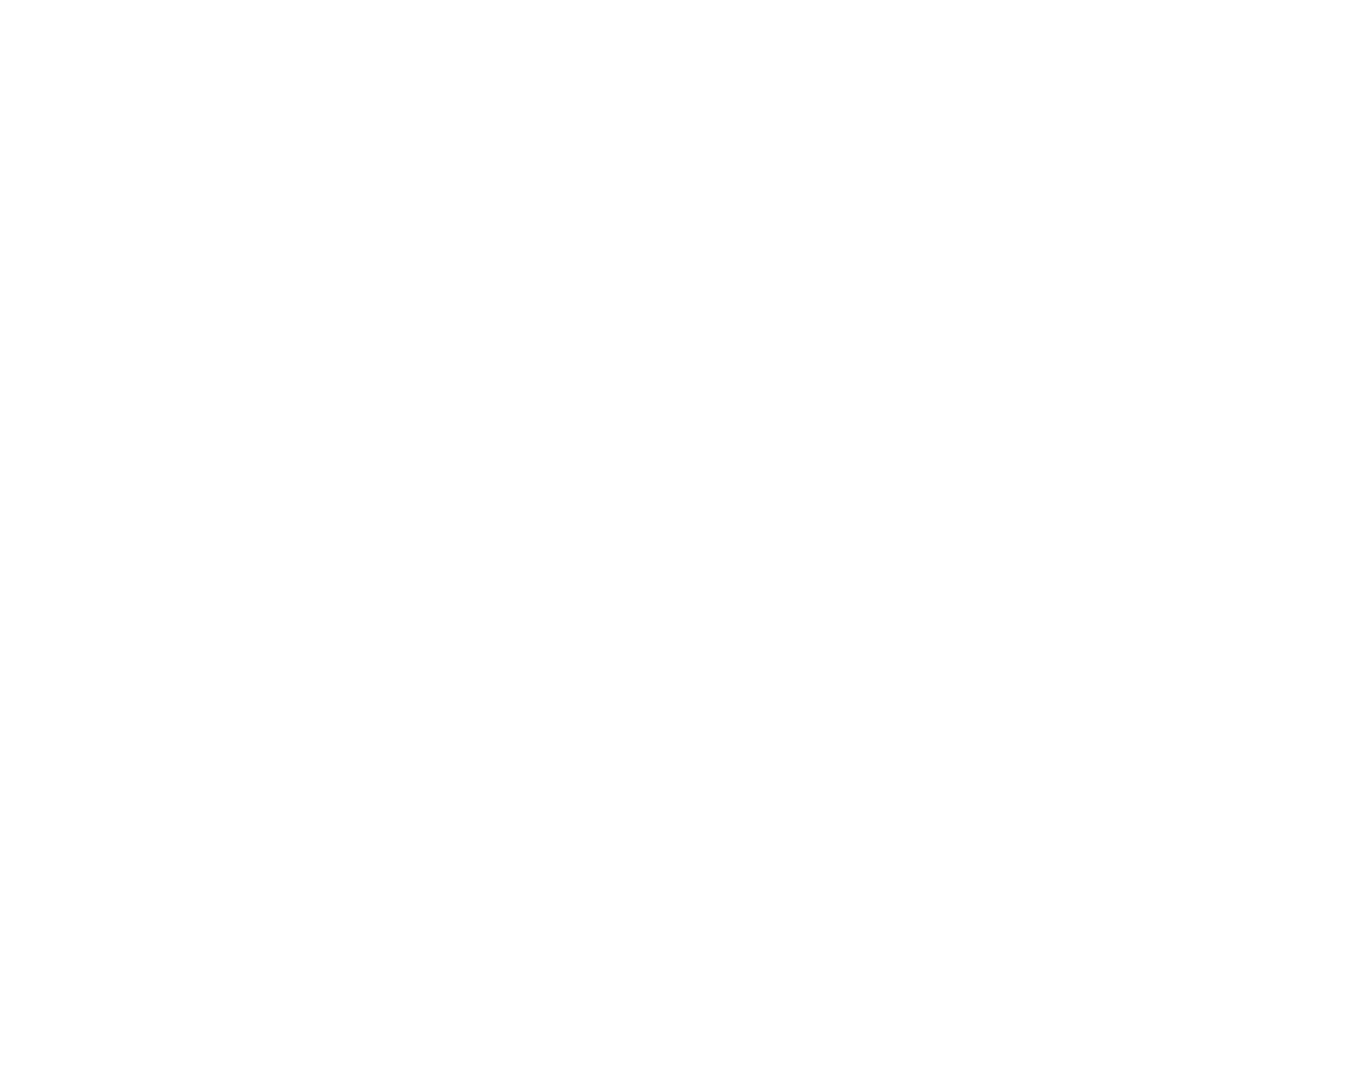

<IPython.core.display.Javascript object>


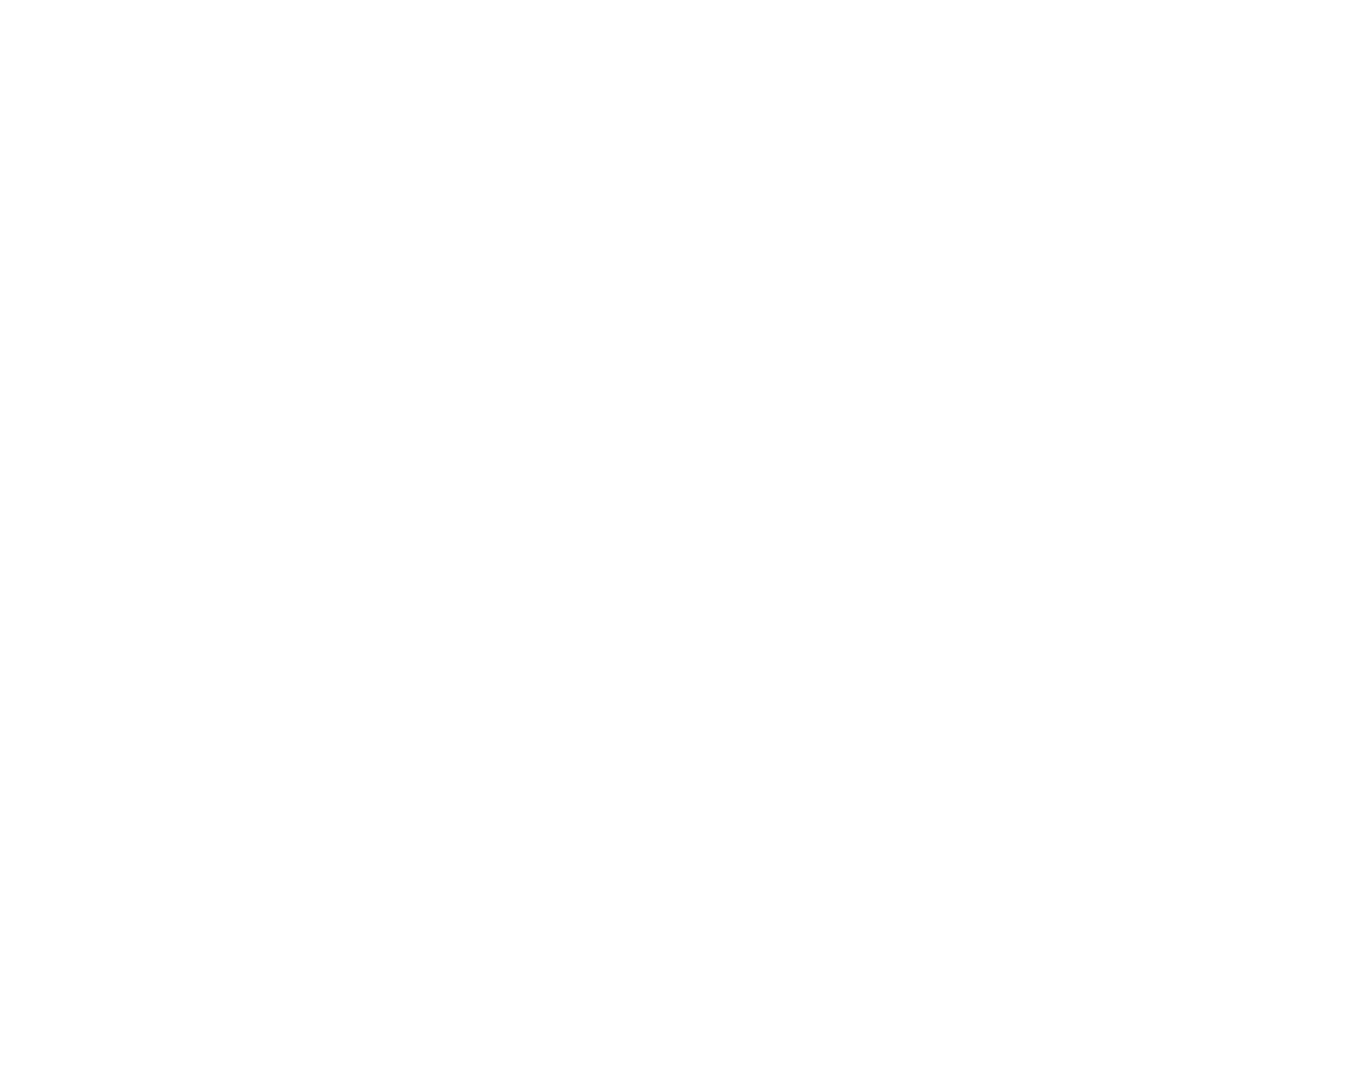

<IPython.core.display.Javascript object>


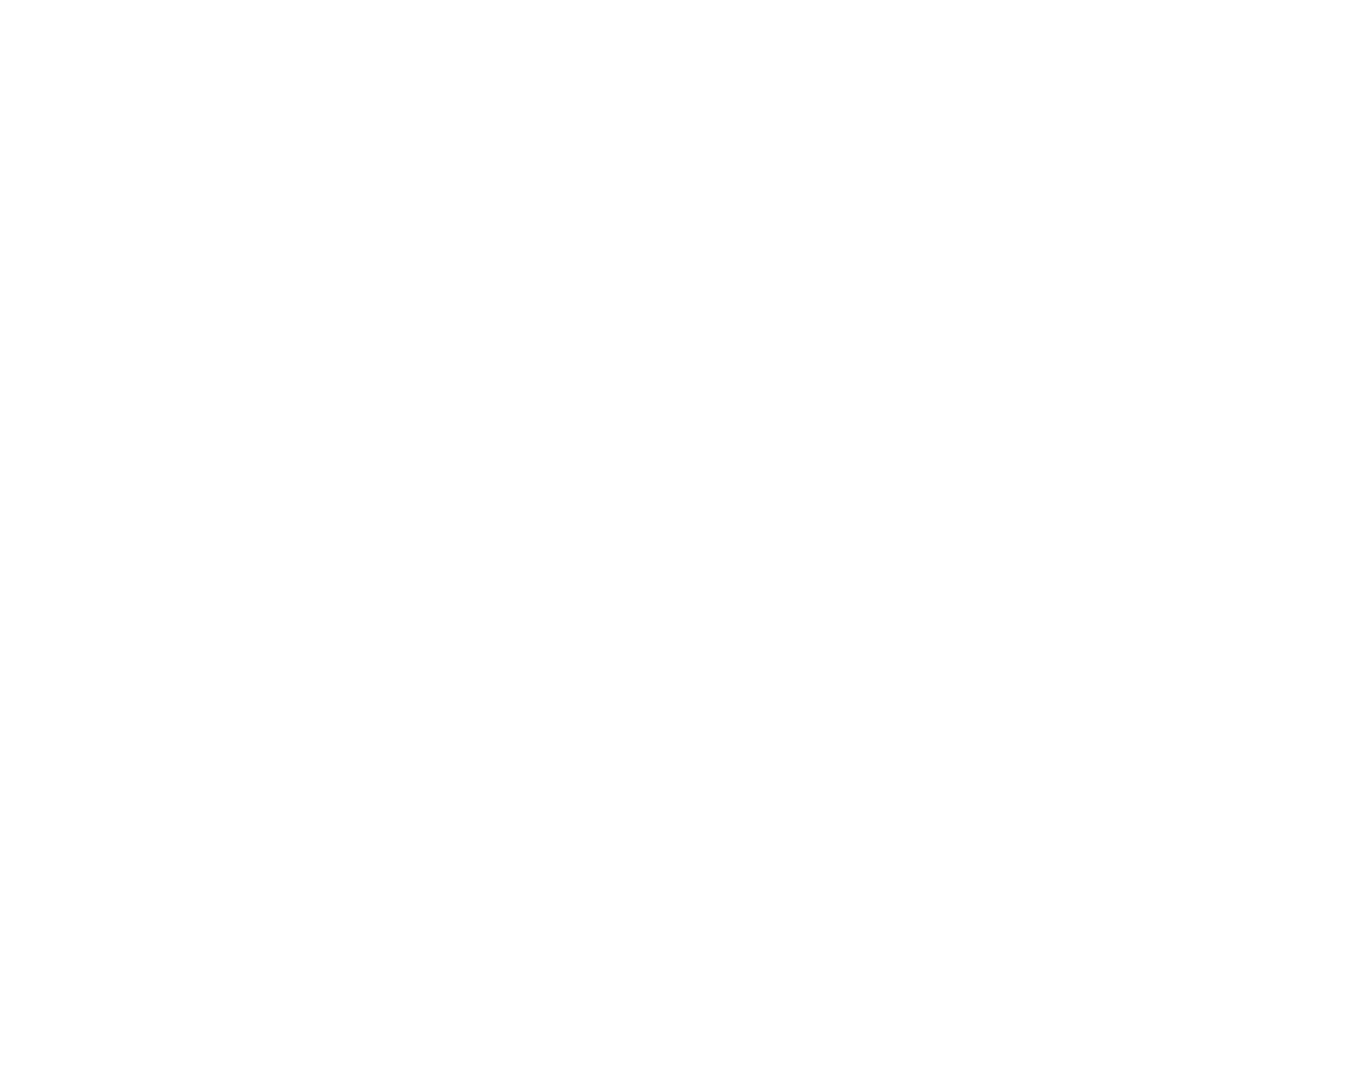

<IPython.core.display.Javascript object>


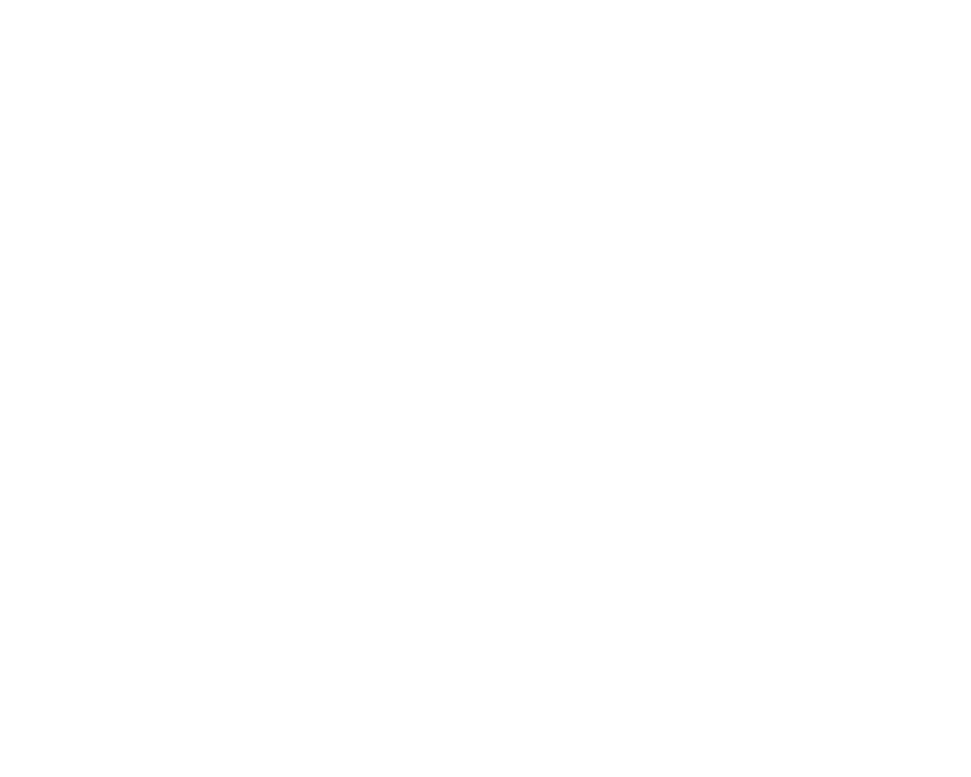

<IPython.core.display.Javascript object>


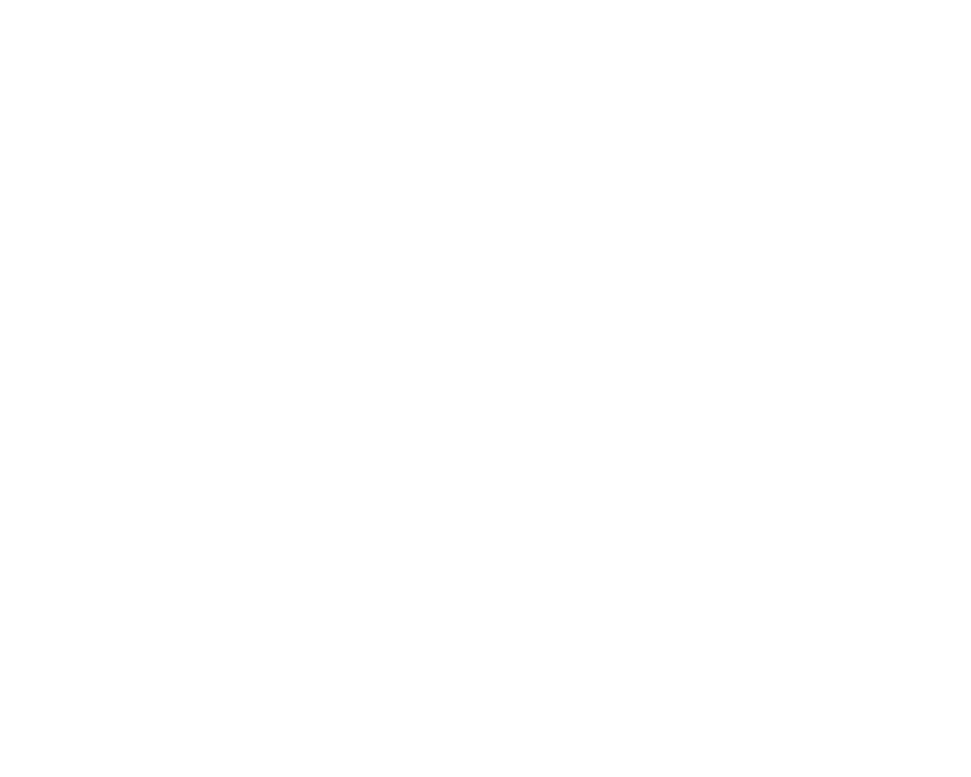

<IPython.core.display.Javascript object>


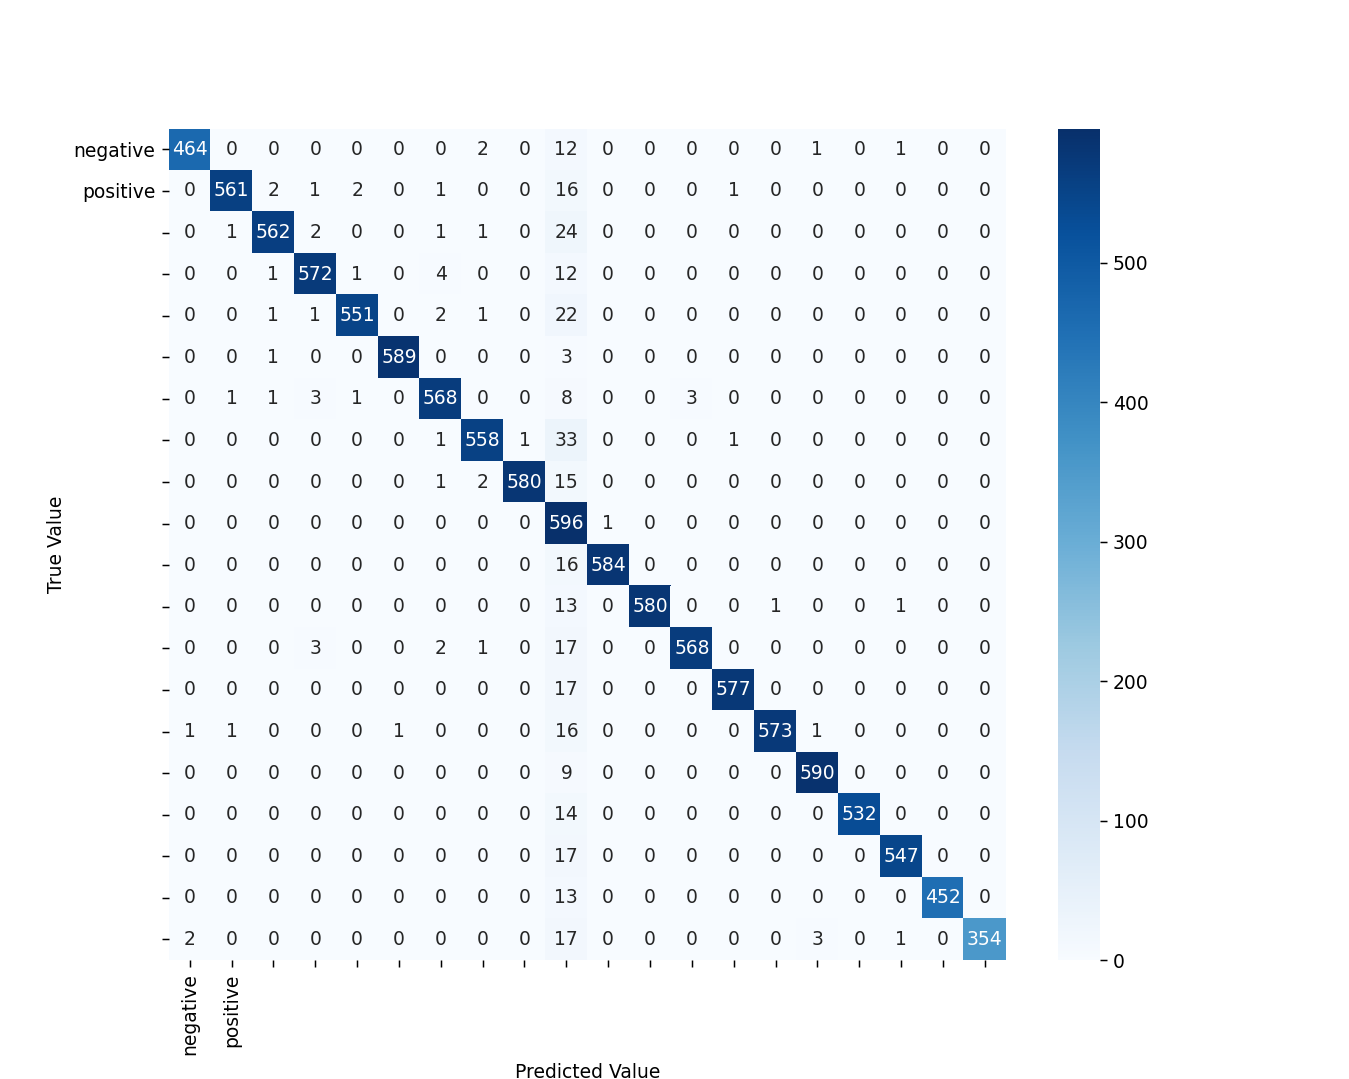

<IPython.core.display.Javascript object>


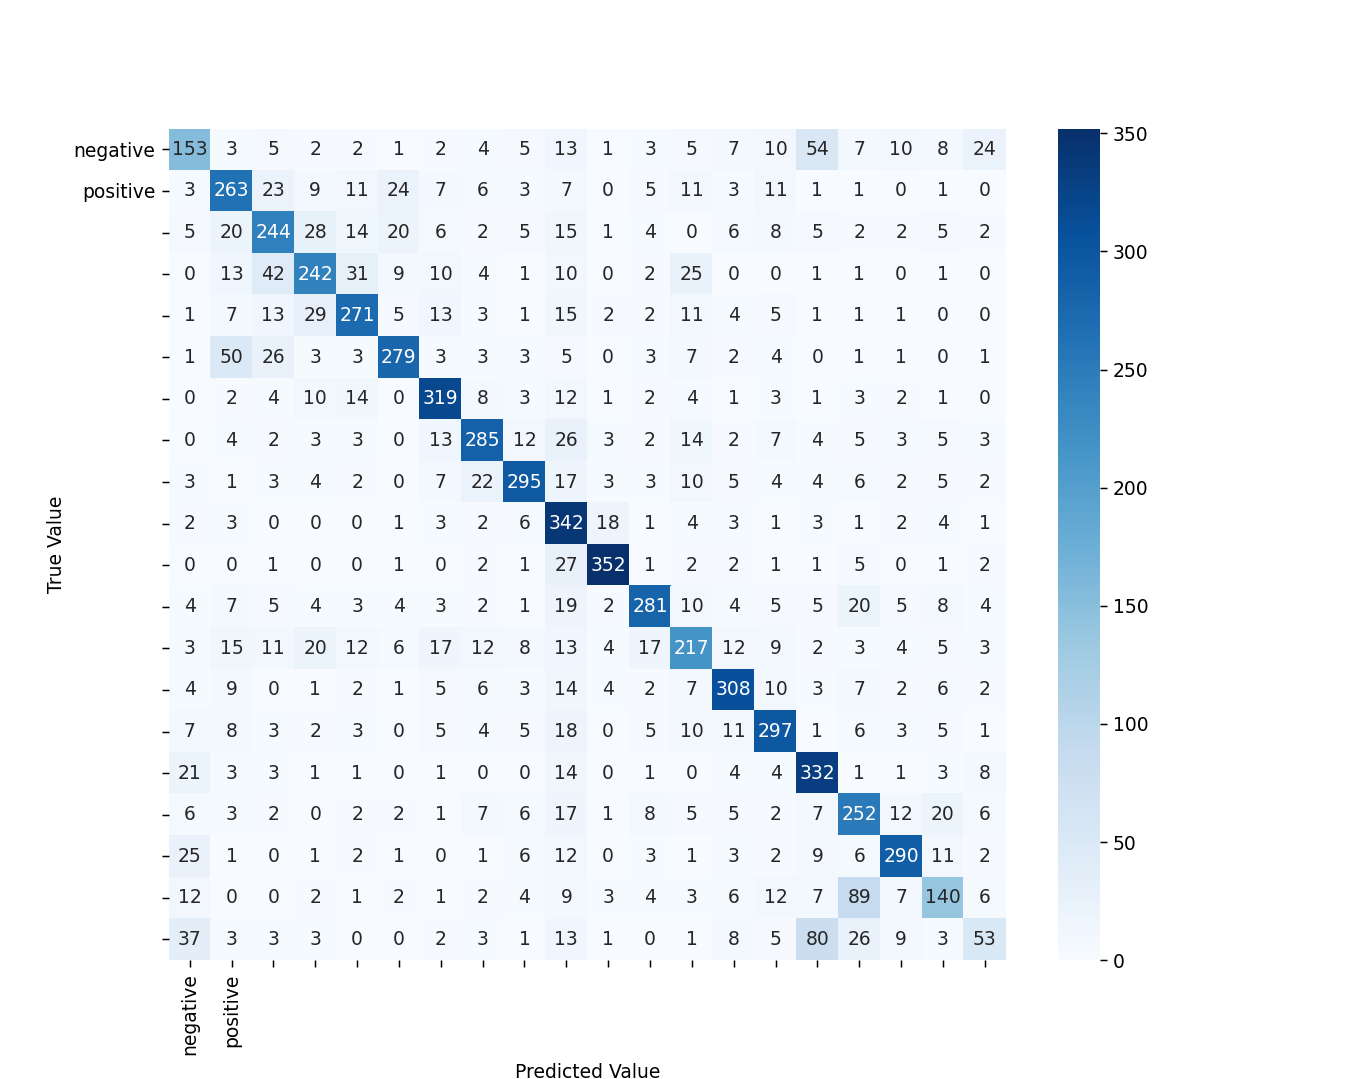

<IPython.core.display.Javascript object>


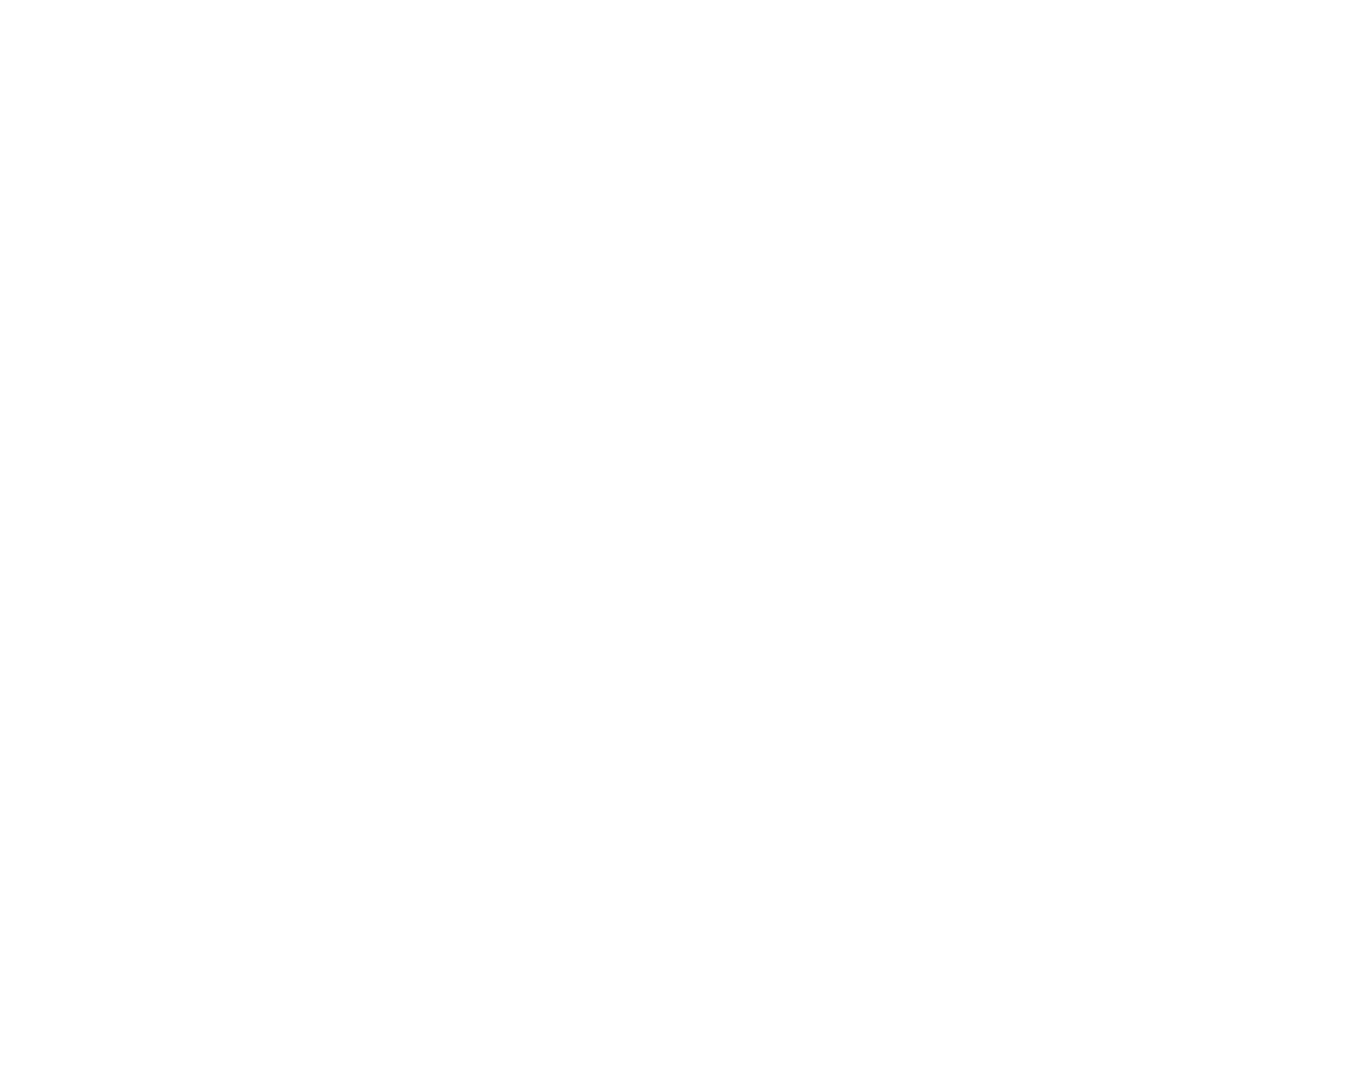

<IPython.core.display.Javascript object>


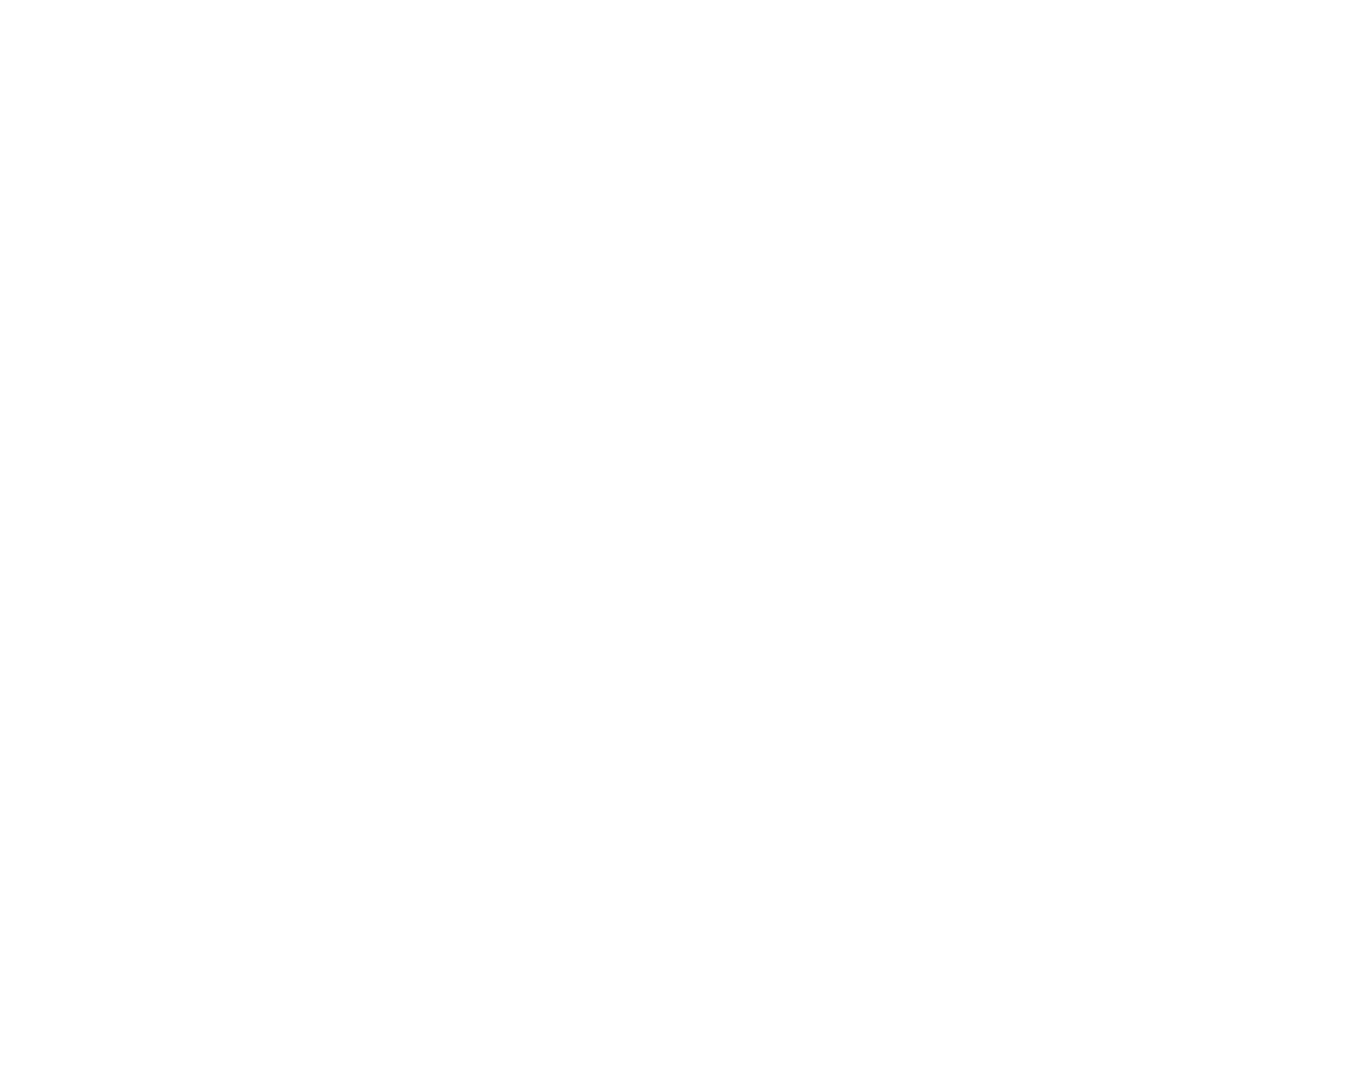

In [95]:
news_binary_ngrams_models = load_models('news_binary_ngrams', model_suffix)

In [96]:
news_binary_ngrams_models
#These models have all been pre-trained
#They can be reproduced exactly by using the parameters shown here with the random_state of 42, and training on movie_binary_ngrams

{'nb': MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False),
 'lr': LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0.2, max_iter=100000,
                    multi_class='auto', n_jobs=-1, penalty='elasticnet',
                    random_state=42, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'ada': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                    n_estimators=1000, random_state=42),
 'forest': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=50, max_features=0.25,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=16,
                        min_weight_fraction_leaf=0.0, n_estimators=200,
         

In [97]:
#Voting , remove any classifiers not needed
news_binary_ngrams_estimators = []
news_binary_ngrams_weights = []



for name, model in news_binary_ngrams_models.items():
    if name != 'dec_tree' and name != 'ada':
        news_binary_ngrams_estimators.append(model)
        news_binary_ngrams_weights.append(news_binary_ngrams_accuracies[name] / news_binary_ngrams_accuracies_max)


In [44]:
news_binary_ngrams_ensemble = EnsembleVoteClassifier(news_binary_ngrams_estimators, voting='hard', weights=news_binary_ngrams_weights, refit=False)


C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


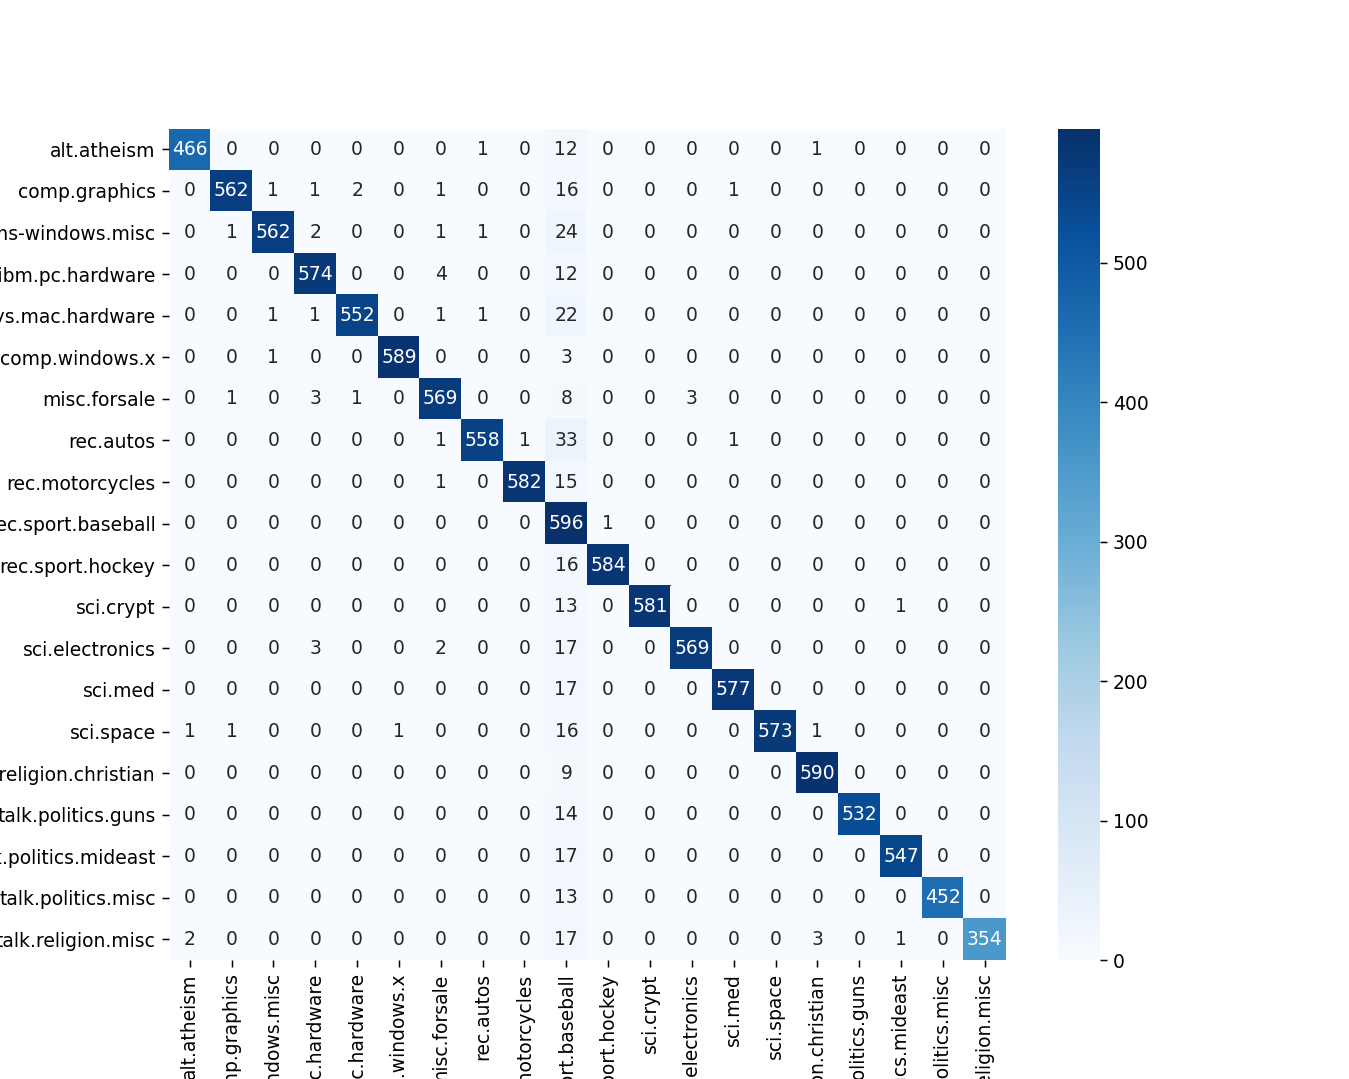

<IPython.core.display.Javascript object>


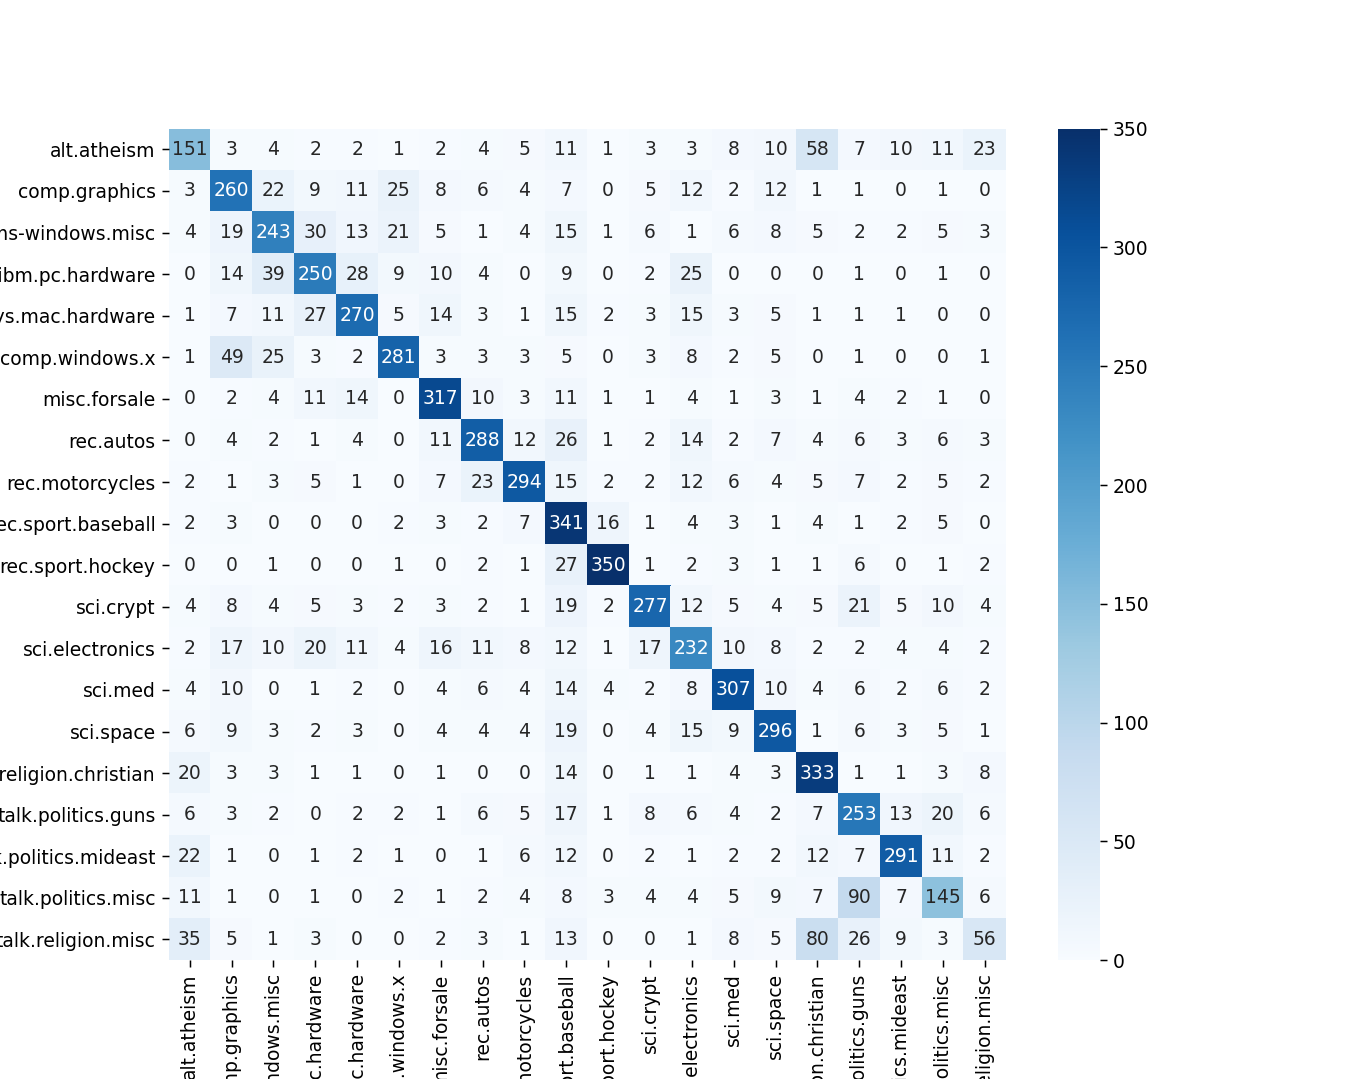

In [45]:
news_binary_ngrams_results_ensemble = ensemble_eval_save("news_binary_ngrams_results_ensemble.pkl", news_binary_ngrams_ensemble, news['news_binary_ngrams']['X_train'], news['news_binary_ngrams']['y_train'],
             news['news_binary_ngrams']['X_test'], news['news_binary_ngrams']['y_test'], news_labels,'micro')

In [46]:
news_binary_ngrams_results_ensemble

{'model': EnsembleVoteClassifier(clfs=[MultinomialNB(alpha=0.1, class_prior=None,
                                            fit_prior=False),
                              LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=0.2, max_iter=100000,
                                                 multi_class='auto', n_jobs=-1,
                                                 penalty='elasticnet',
                                                 random_state=42, solver='saga',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False),
                              RandomForestClassifier(...
                                                     oob_score=False,
                                                    

# Soft Ensemble

In [47]:
news_binary_ngrams_svc = SVC(C = 0.39, kernel='linear', probability=True, max_iter = 10000, cache_size = 20000,
                             break_ties=False, random_state=42)

C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


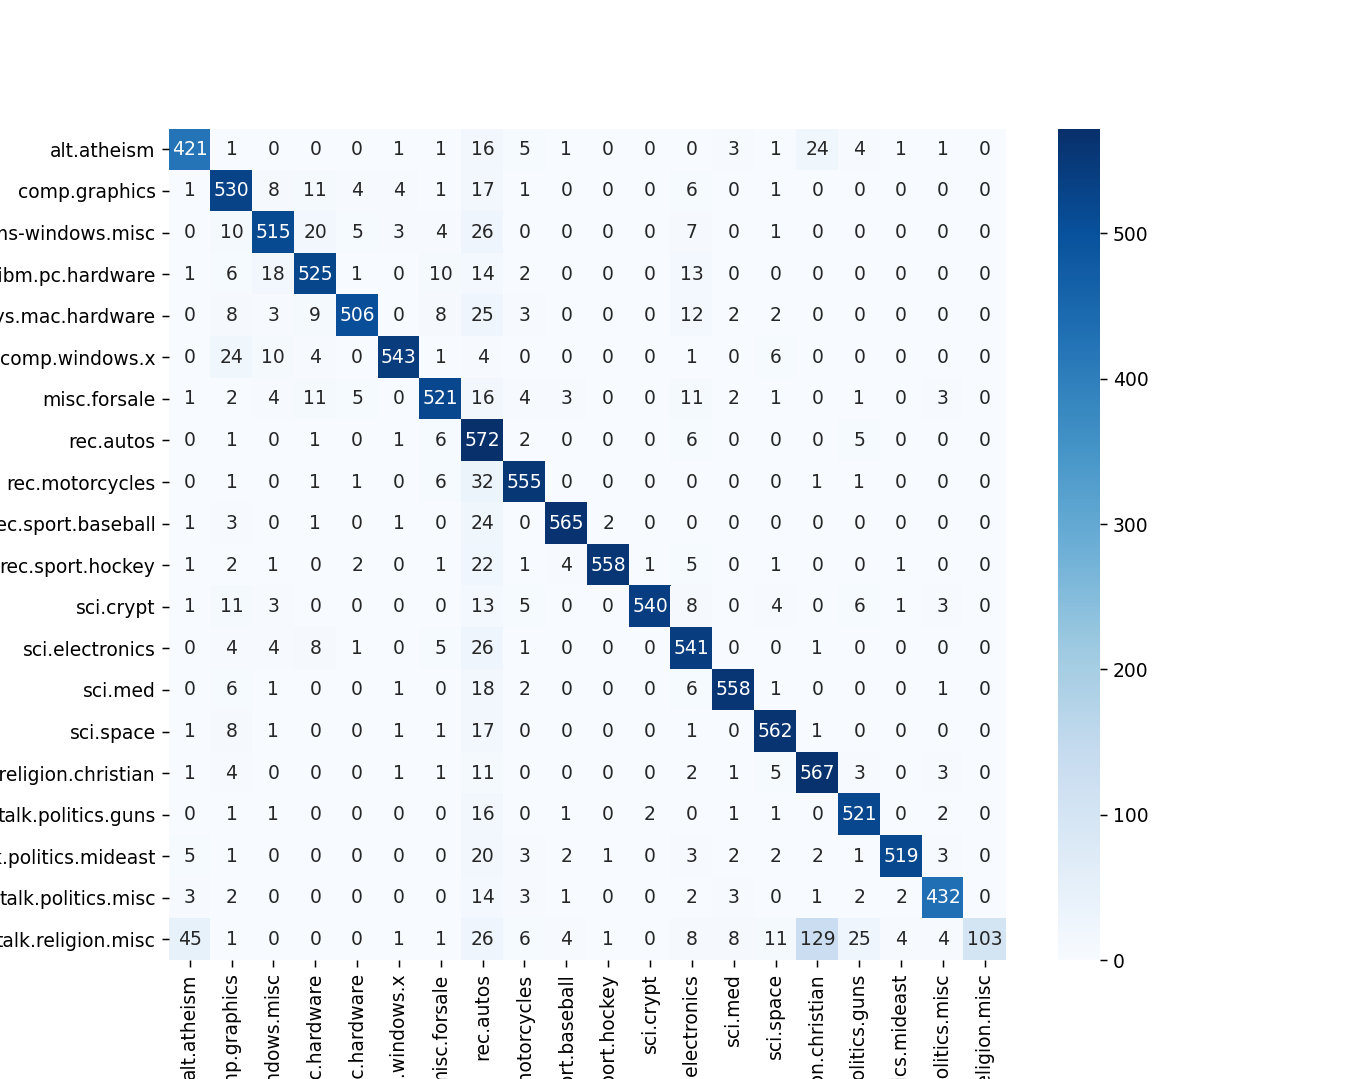

<IPython.core.display.Javascript object>


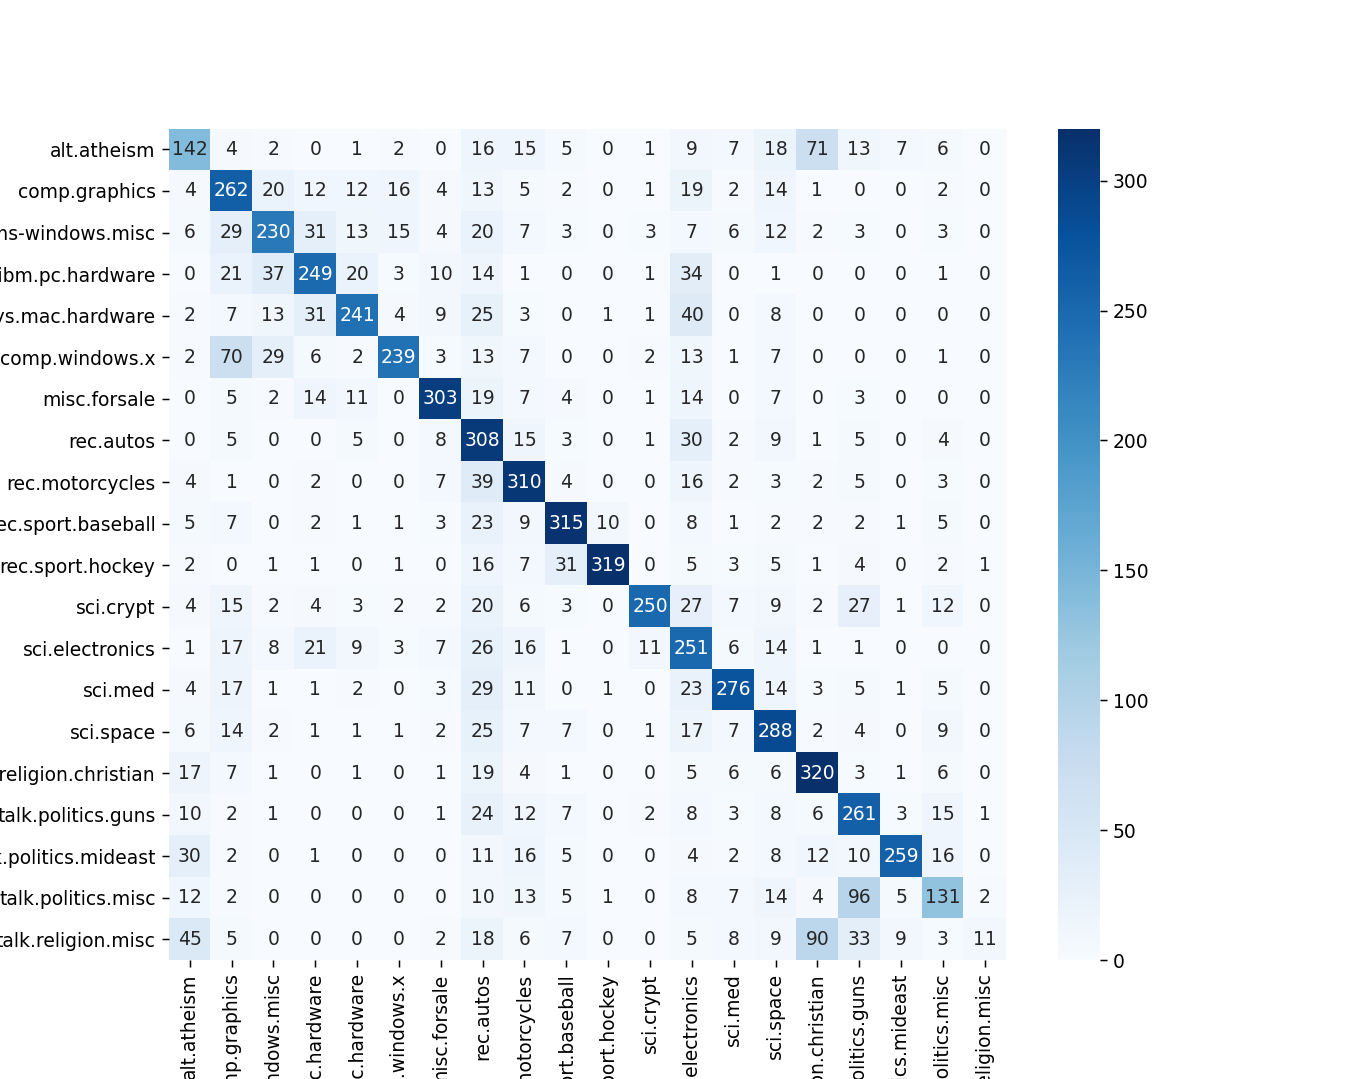

In [48]:
news_binary_ngrams_results_svc_proba = ensemble_eval_save("news_binary_ngrams_results_svc_proba.pkl", news_binary_ngrams_svc, news['news_binary_ngrams']['X_train'], news['news_binary_ngrams']['y_train'],
             news['news_binary_ngrams']['X_test'], news['news_binary_ngrams']['y_test'], news_labels,'micro')

In [49]:
news_binary_ngrams_results_svc_proba

{'model': SVC(C=0.39, break_ties=False, cache_size=20000, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
     max_iter=10000, probability=True, random_state=42, shrinking=True,
     tol=0.001, verbose=False),
 'train_results': {'acc': 0.8974721583878381,
  'f1': 0.8974721583878381,
  'conf_matrix': array([[421,   1,   0,   0,   0,   1,   1,  16,   5,   1,   0,   0,   0,
            3,   1,  24,   4,   1,   1,   0],
         [  1, 530,   8,  11,   4,   4,   1,  17,   1,   0,   0,   0,   6,
            0,   1,   0,   0,   0,   0,   0],
         [  0,  10, 515,  20,   5,   3,   4,  26,   0,   0,   0,   0,   7,
            0,   1,   0,   0,   0,   0,   0],
         [  1,   6,  18, 525,   1,   0,  10,  14,   2,   0,   0,   0,  13,
            0,   0,   0,   0,   0,   0,   0],
         [  0,   8,   3,   9, 506,   0,   8,  25,   3,   0,   0,   0,  12,
            2,   2,   0,   0,   0,   0,   0],
         [  0,  24,  10,   4,   0, 5

In [53]:
news_binary_ngrams_accuracies_soft = news_binary_ngrams_accuracies.copy()
del news_binary_ngrams_accuracies_soft['linear_svc']
news_binary_ngrams_accuracies_soft['svc'] = 0.65919
news_binary_ngrams_accuracies_soft_max = max(news_binary_ngrams_accuracies_soft.values())

news_binary_ngrams_models_soft = news_binary_ngrams_models
del news_binary_ngrams_models_soft['linear_svc']
news_binary_ngrams_models_soft['svc'] = news_binary_ngrams_svc

news_binary_ngrams_estimators_soft = []
news_binary_ngrams_weights_soft = []

for name, model in news_binary_ngrams_models_soft.items():
    if name != 'dec_tree' and name != 'ada':
        news_binary_ngrams_estimators_soft.append(model)
        news_binary_ngrams_weights_soft.append(news_binary_ngrams_accuracies_soft[name] / news_binary_ngrams_accuracies_soft_max)

news_binary_ngrams_ensemble_weights_soft = EnsembleVoteClassifier(news_binary_ngrams_estimators_soft, weights = news_binary_ngrams_weights_soft, voting='soft', refit=False)

C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


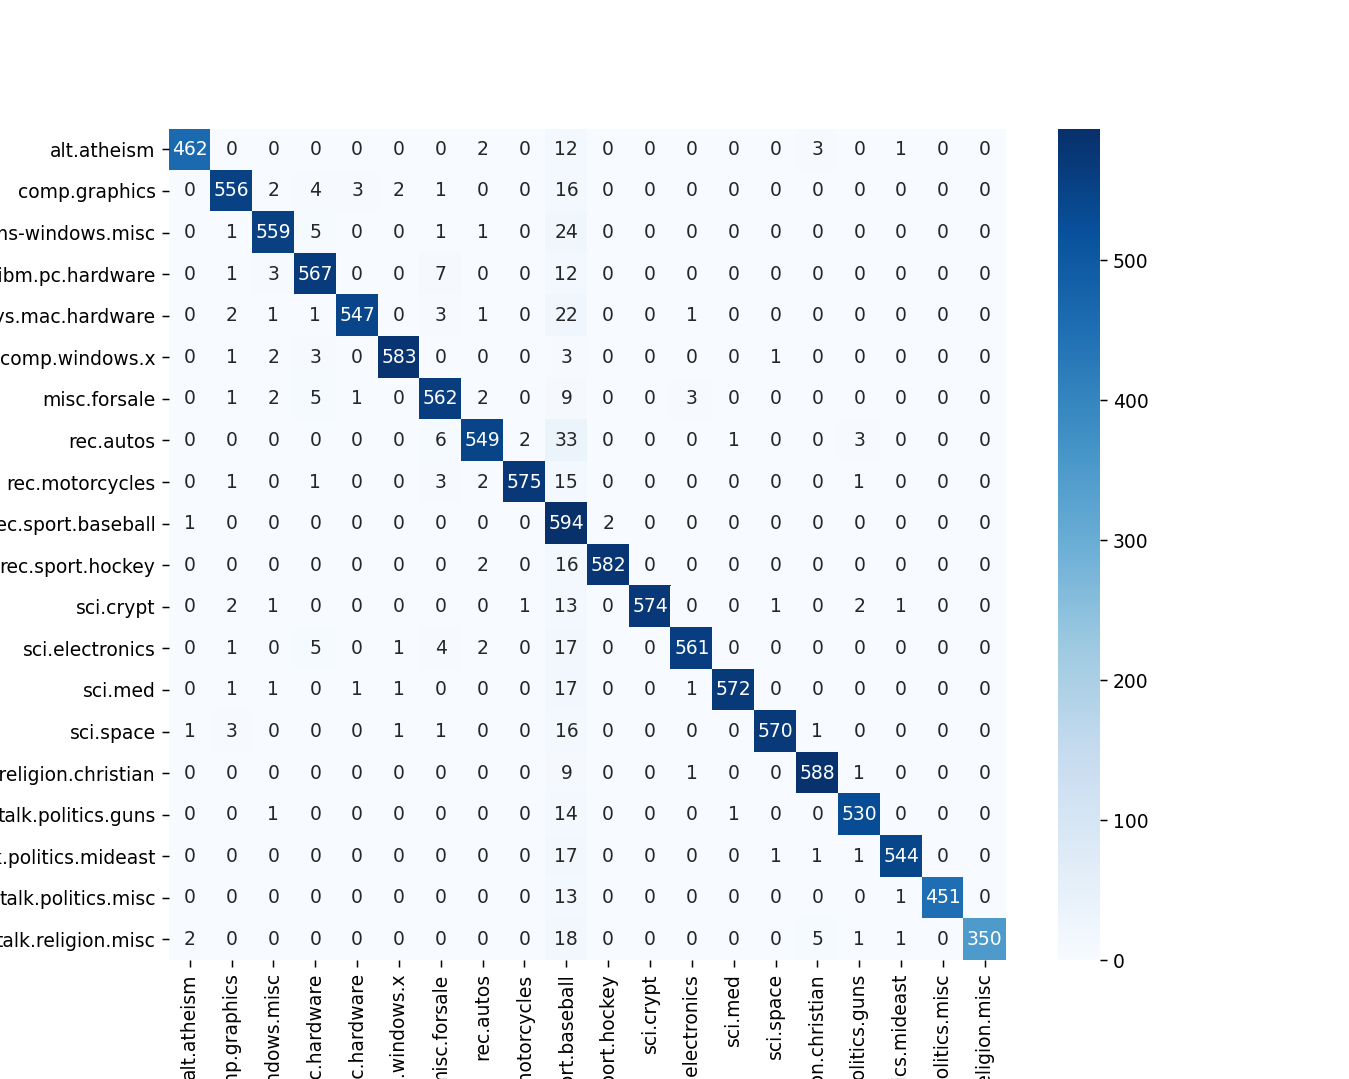

<IPython.core.display.Javascript object>


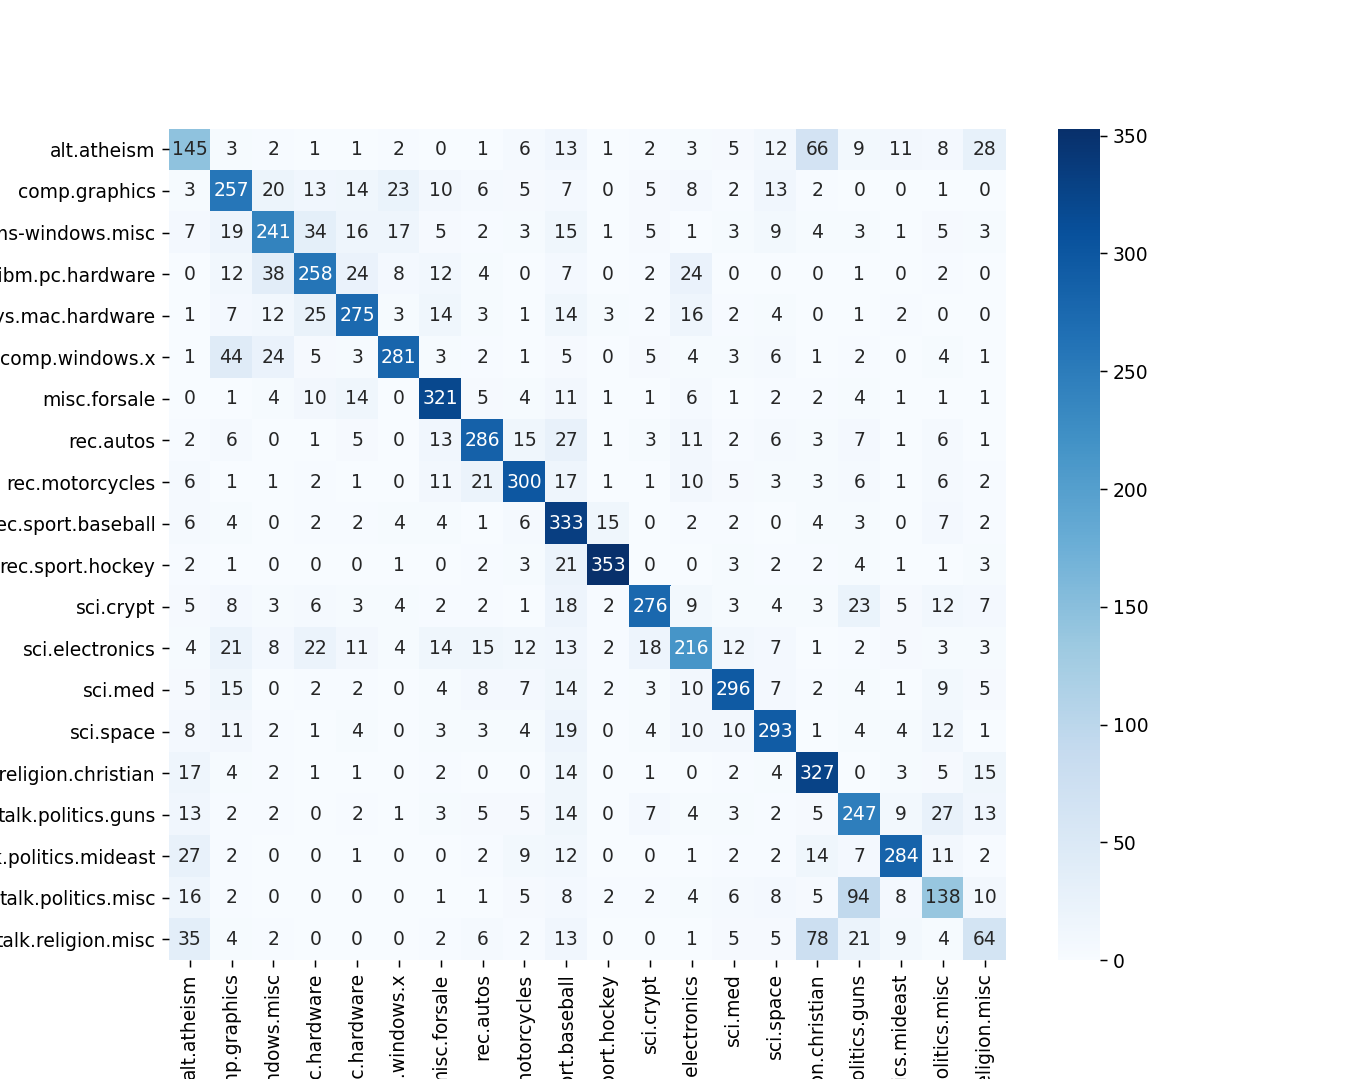

In [55]:
news_binary_ngrams_results_ensemble_weights_soft = ensemble_eval_save("news_binary_ngrams_results_ensemble_weights_soft.pkl", news_binary_ngrams_ensemble_weights_soft, news['news_binary_ngrams']['X_train'], news['news_binary_ngrams']['y_train'],
             news['news_binary_ngrams']['X_test'], news['news_binary_ngrams']['y_test'], news_labels,'micro')

In [56]:
news_binary_ngrams_results_ensemble_weights_soft

{'model': EnsembleVoteClassifier(clfs=[MultinomialNB(alpha=0.1, class_prior=None,
                                            fit_prior=False),
                              LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=0.2, max_iter=100000,
                                                 multi_class='auto', n_jobs=-1,
                                                 penalty='elasticnet',
                                                 random_state=42, solver='saga',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False),
                              RandomForestClassifier(...
                                                     warm_start=False),
                              SVC(C=0.39, break_ti

## Stacking Ensemble

In [103]:
#Voting , remove any classifiers not needed
news_binary_ngrams_estimators_stack = []
news_binary_ngrams_weights_stack = []

for name, model in news_binary_ngrams_models.items():
    news_binary_ngrams_estimators_stack.append(model)
    news_binary_ngrams_weights_stack.append(news_binary_ngrams_accuracies[name] / news_binary_ngrams_accuracies_max)

meta_lr = LogisticRegression()    

news_binary_ngrams_ensemble_stack = StackingCVClassifier(classifiers = news_binary_ngrams_estimators_stack, meta_classifier = meta_lr, 
                                                          cv=5, random_state=42, verbose=2, n_jobs=-1)


In [104]:
news_binary_ngrams_ensemble_stack

StackingCVClassifier(classifiers=[MultinomialNB(alpha=0.1, class_prior=None,
                                                fit_prior=False),
                                  LogisticRegression(C=10, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=0.2,
                                                     max_iter=100000,
                                                     multi_class='auto',
                                                     n_jobs=-1,
                                                     penalty='elasticnet',
                                                     random_state=42,
                                                     solver='saga', tol=0.0001,
                                                     verbose=0,
    

In [105]:
news_binary_ngrams_results_ensemble_stack = ensemble_eval_save("news_binary_ngrams_results_ensemble_stack.pkl", news_binary_ngrams_ensemble_stack, news['news_binary_ngrams']['X_train'], news['news_binary_ngrams']['y_train'],
             news['news_binary_ngrams']['X_test'], news['news_binary_ngrams']['y_test'], news_labels,'micro')

Fitting 6 classifiers...
Fitting classifier1: multinomialnb (1/6)
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: logisticregression (2/6)
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=100000,
                   multi_class='auto', n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.5min remaining: 20.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: adaboostclassifier (3/6)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=1000, random_state=42)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.9min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier4: randomforestclassifier (4/6)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=16,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.3min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier5: linearsvc (5/6)
LinearSVC(C=0.39, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier6: decisiontreeclassifier (6/6)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10000, max_features=0.75, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=128,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.4s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished
C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

<IPython.core.display.Javascript object>

C:\Users\Lenovo\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

In [106]:
news_binary_ngrams_results_ensemble_stack

{'model': StackingCVClassifier(classifiers=[MultinomialNB(alpha=0.1, class_prior=None,
                                                 fit_prior=False),
                                   LogisticRegression(C=10, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=0.2,
                                                      max_iter=100000,
                                                      multi_class='auto',
                                                      n_jobs=-1,
                                                      penalty='elasticnet',
                                                      random_state=42,
                                                      solver='saga', tol=0.0001,
                                              